# Exploring Modifications to TLA

In [4]:
%load_ext autoreload
import sys
sys.path.append("/Users/gregoryridgway/Desktop/DM/DH/DarkHistory/")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Notebook Initialization

In [5]:
%autoreload
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = [10,10]

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams["mathtext.fontset"] = "stix"

matplotlib.rcParams['axes.titlepad'] = 15
matplotlib.rcParams['axes.titlesize'] = 36
matplotlib.rcParams['axes.labelsize'] = 28
matplotlib.rcParams['axes.linewidth'] = 2
matplotlib.rcParams['axes.formatter.min_exponent'] = 2


matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['xtick.bottom'] = True
matplotlib.rcParams['xtick.major.size'] = 10
matplotlib.rcParams['xtick.major.width'] = 2
matplotlib.rcParams['xtick.minor.size'] = 3
matplotlib.rcParams['xtick.minor.width'] = 1
matplotlib.rcParams['xtick.labelsize'] = 24
matplotlib.rcParams['xtick.direction'] = 'in'

matplotlib.rcParams['ytick.left'] = True
matplotlib.rcParams['ytick.right'] = True
matplotlib.rcParams['ytick.major.size'] = 10
matplotlib.rcParams['ytick.major.width'] = 2
matplotlib.rcParams['ytick.minor.size'] = 3
matplotlib.rcParams['ytick.minor.width'] = 1
matplotlib.rcParams['ytick.labelsize'] = 24
matplotlib.rcParams['ytick.direction'] = 'in'

matplotlib.rcParams['lines.linewidth'] = 2.5

matplotlib.rcParams['legend.fontsize'] = 24

import pickle
import numpy as np
# np.set_printoptions(threshold=np.nan)

import darkhistory.physics as phys
from scipy.integrate import odeint
from scipy.interpolate import interp1d
from scipy.interpolate import interp2d
from scipy.integrate import quad
import scipy.special

from scipy.interpolate import RegularGridInterpolator
import darkhistory.history.dark_tla as dark_tla
import darkhistory.history.tla as tla

from tqdm import tqdm_notebook as tqdm

# Atomic Constants

In [6]:
# From Kim and Vivian's paper, Fig. 5 top panel
f_vs_mDM = scipy.interpolate.interp1d(
    np.array([.2,.5,1,2,5,10,30]), np.array([5e-5,1e-4,2e-4,5e-4,1e-3,2e-3,4e-3])#, bounds_error=False, fill_value=(5e-5,datums[-1,1])
)

In [7]:
# For improved stability, find the point where 
# Saha equilibrium predicts xe ~ 99%
def find_rs_start(alphaD, m_be, m_bp, xi, verbose = False):
    # I would to find the redshift at which x_e is between these two values
    lower_xe = .99
    upper_xe = .999

    # My initial guess for that redshift, and the x_e at that redshift
    rs_start = 1e4
    x_be = dark_tla.x_be_Saha(rs_start, alphaD, m_be, m_bp, xi)

    # Double or halve the redshift
    log_step = 2

    iterate=0
    while x_be<lower_xe or x_be>upper_xe:
        iterate += 1
        if x_be<lower_xe:
            rs_start *= log_step
            x_be = dark_tla.x_be_Saha(rs_start, alphaD, m_be, m_bp, xi)

            #overstepped the bounds
            if x_be>upper_xe:
                log_step -= np.log10(log_step)

        elif x_be>upper_xe:
            rs_start /= log_step
            x_be = dark_tla.x_be_Saha(rs_start, alphaD, m_be, m_bp, xi)

            #overstepped the bounds
            if x_be<lower_xe:
                log_step -= np.log10(log_step)
    if verbose:
        print('redshift:', rs)
        print('x_be: ', x_be)
        print('iterations: ', iterate)
        
    return rs_start

### Cross-Checks

1. TLA can reproduce the SM result.

In [8]:
%autoreload
rs_list = 10**np.arange(3.477,0,-.01)
history0 = tla.get_history(rs_list, reion_switch=False)

alphaD, m_be, m_bp, xi = phys.alpha, phys.me, phys.mp, 1.0
rs_start = find_rs_start(alphaD, m_be, m_bp, xi)

rs_list_DM = 10**np.arange(np.log10(rs_start),np.log10(1),-1e-3)
dark_history = dark_tla.get_history(
    rs_list_DM,alphaD=alphaD, m_be=m_be, m_bp=m_bp, xi=xi, eps=0
)

!!! The difference is resolved when we set n_DM = n_H


[None, None]

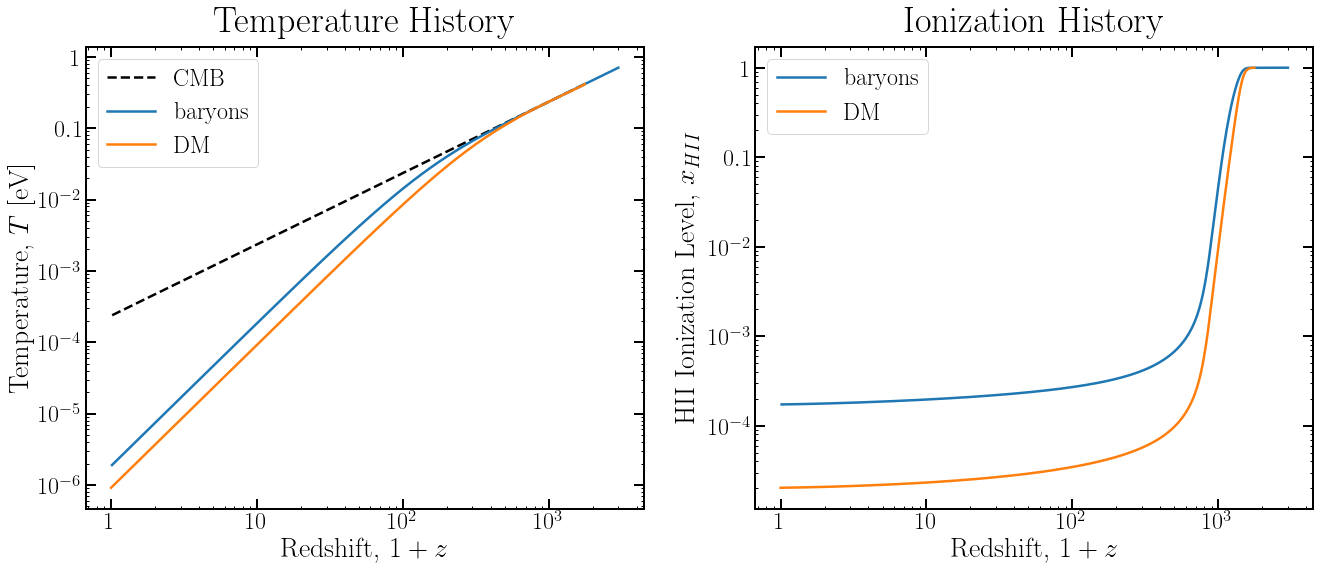

In [9]:
plt.figure(figsize=(22,8.5))
print('!!! The difference is resolved when we set n_DM = n_H')

plt.subplot(1, 2, 1)
plt.plot(rs_list_DM, phys.TCMB(rs_list_DM), color='k', linestyle='--', label='CMB')
plt.plot(rs_list, history0[:,0], label='baryons')
plt.plot(rs_list_DM, dark_history[:,0], label='DM')
plt.xlabel(r'Redshift, $1+z$')
plt.ylabel(r'Temperature, $T$ [eV]')
plt.title('Temperature History')
plt.loglog()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(rs_list, history0[:,1], label='baryons')
plt.plot(rs_list_DM, dark_history[:,1], label='DM')#, linestyle='--')
# plt.axis([0.1,1e11, 1e-12,1.5])
plt.xlabel(r'Redshift, $1+z$')
plt.ylabel(r'HII Ionization Level, $x_{HII}$')
plt.title('Ionization History')
plt.loglog()
# plt.xticks(10.0**np.arange(0,12,2))
# plt.yticks(10.0**np.arange(-11,1,2))
leg = plt.legend(fontsize=24)
plt.setp(leg.get_title(),fontsize=24)

2. Can reproduce Cyr-Racine's Fig. 5 left panel

In [10]:
import csv
xe_hist_data = []
with open('/Users/gregoryridgway/Desktop/Webplot Digitizer/Atomic/example_history.csv') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
         xe_hist_data.append([float(row[0]),float(row[1])])
xe_hist_data = np.array(xe_hist_data)

Tm_hist_data = []
with open('/Users/gregoryridgway/Desktop/Webplot Digitizer/Atomic/T_m_hist.csv') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
         Tm_hist_data.append([float(row[0]),float(row[1])])
Tm_hist_data = np.array(Tm_hist_data)

In [11]:
%autoreload

rs_list = 10**np.arange(3.477,0,-.01)
history0 = tla.get_history(rs_list, reion_switch=False)

m_be, m_bp, xi, alphaD = 438585716, 581414284, 0.2, 0.4
rs_start = find_rs_start(alphaD, m_be, m_bp, xi)

log_rs_list_DM = np.arange(np.log(rs_start),0,-.001)
rs_list_DM = np.exp(log_rs_list_DM)
dark_history = dark_tla.get_history(
    rs_list_DM, alphaD=alphaD, m_be=m_be, m_bp=m_bp, xi=xi,
    rtol = 1e-6
)

[None, None]

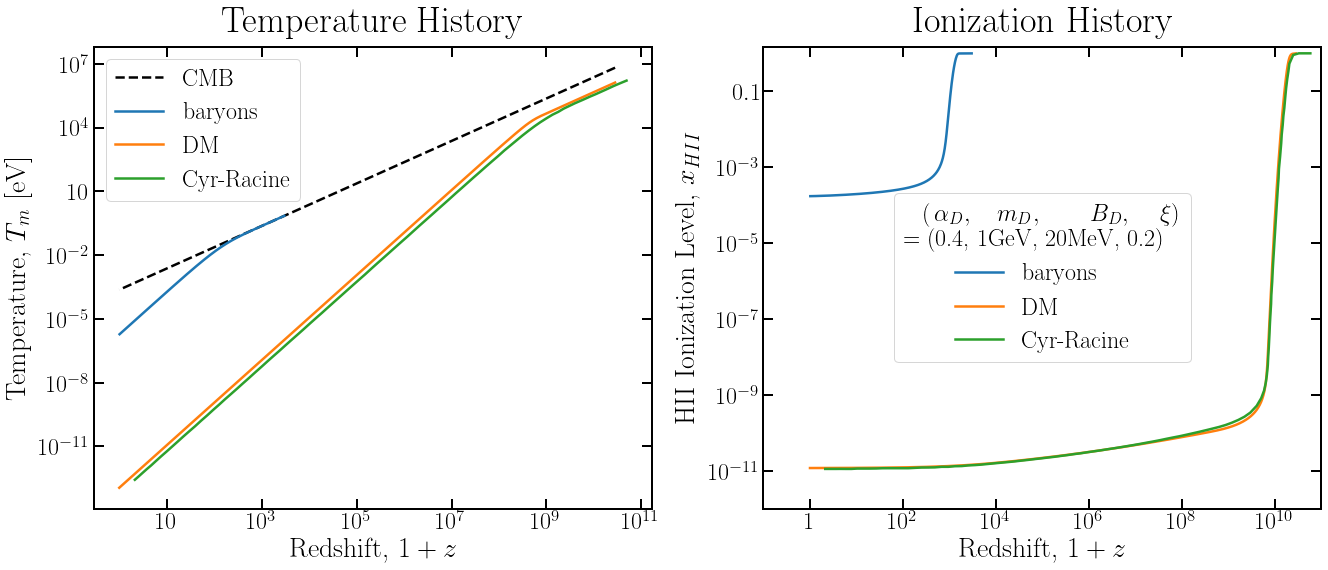

In [12]:
plt.figure(figsize=(22,8.5))

plt.subplot(1, 2, 1)
plt.plot(rs_list_DM, phys.TCMB(rs_list_DM), color='k', linestyle='--', label='CMB')
plt.plot(rs_list, history0[:,0], label='baryons')
plt.plot(rs_list_DM, dark_history[:,0], label='DM')
plt.plot(Tm_hist_data[:,0]+1, Tm_hist_data[:,1], label='Cyr-Racine')
plt.xlabel(r'Redshift, $1+z$')
plt.ylabel(r'Temperature, $T_m$ [eV]')
plt.title('Temperature History')
# plt.axvline(2e8)
plt.loglog()
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(rs_list, history0[:,1], label='baryons')
plt.plot(rs_list_DM, dark_history[:,1], label='DM')#, linestyle='--')
plt.plot(xe_hist_data[:,0]+1, xe_hist_data[:,1], label='Cyr-Racine')
plt.axis([0.1,1e11, 1e-12,1.5])
plt.xlabel(r'Redshift, $1+z$')
plt.ylabel(r'HII Ionization Level, $x_{HII}$')
plt.title('Ionization History')
plt.loglog()
plt.xticks(10.0**np.arange(0,12,2))
plt.yticks(10.0**np.arange(-11,1,2))
leg = plt.legend(fontsize=24)
#leg.set_title(r'$\,(\, \alpha_D,\;\;\;$ $m_{\textbf{e}}, \qquad$ $m_{\textbf{p}}, \;\;\;\,$ $\xi$) \\='
leg.set_title(r'$\,(\, \alpha_D,\;\;\;$ $m_{D}, \qquad$ $B_D, \;\;\;\,$ $\xi$) \\='
           +' (0.4, 1GeV, 20MeV, 0.2)')
plt.setp(leg.get_title(),fontsize=24)
# plt.savefig('/Users/gregoryridgway/Dropbox (MIT)/Atomic DM/figs/mbe_mbp_30MeV_alphaD_4e-3_xi_2e-1.png')

3. Fig. 4 top panel.  Do I get Rayleigh, brem, ion, exc correct?

In [13]:
%autoreload
B_D = dark_tla.get_BD(alphaD, m_be, m_bp)
m_D = m_be + m_bp - B_D
n_D = phys.rho_DM/m_D * rs_list_DM**3
T_DM = dark_history[:,0]
x_be = dark_history[:,1]
T_D = phys.TCMB(rs_list_DM)*xi
eps = 1-T_DM/T_D

funcs = {'comp': dark_tla.norm_compton_cooling_rate, 
         'R': dark_tla.Gam_R, 'ff': dark_tla.Gam_ff, 
         'pr': dark_tla.Gam_pr, 'pi': dark_tla.Gam_pi}

rates = {}
for key in funcs:
    rates[key] = funcs[key](x_be, T_DM, rs_list_DM, alphaD, m_be, m_bp, xi)

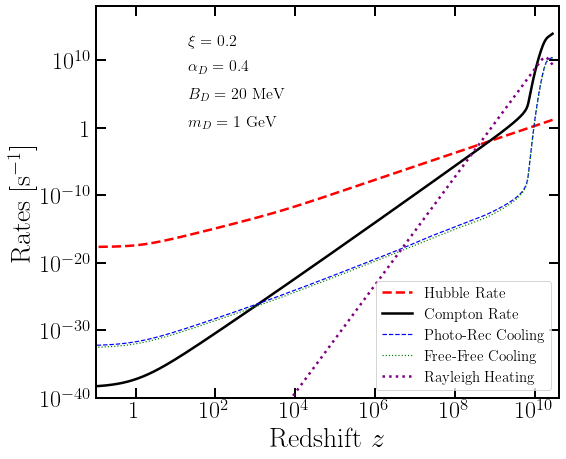

In [14]:
sub = 0.07
plt.figure(figsize=(8.3,7.2))
plt.loglog()
ax=plt.gca()
plt.axis([.1, 4e10, 1e-40,1e18])
plt.yticks(10.0**np.arange(-40,20,10))
plt.xticks(10.0**np.arange(0,12,2))

plt.plot(rs_list_DM-1, phys.hubble(rs_list_DM), color='red', linestyle='--', label='Hubble Rate')
plt.plot(rs_list_DM-1, rates['comp'], color='k', label='Compton Rate')
plt.plot(rs_list_DM-1, rates['pr'], color='blue', linestyle='--', linewidth=1.2, label='Photo-Rec Cooling')
plt.plot(rs_list_DM-1, rates['ff'], color='g', linestyle=':', linewidth=1.2, label='Free-Free Cooling')
plt.plot(rs_list_DM-1, rates['R'], color='purple', linestyle=':', label='Rayleigh Heating')

plt.ylabel(r'Rates [s$^{-1}$]')
plt.xlabel(r'Redshift $z$')
# plt.axvline(8644365919.523441, color='k', linestyle='--', linewidth=1.0)
plt.text(0.2, 0.9, r'$\xi=0.2$', fontsize=16, transform=ax.transAxes)
plt.text(0.2, 0.9-sub, r'$\alpha_D=0.4$', fontsize=16, transform=ax.transAxes)
plt.text(0.2, 0.9-2*sub, r'$B_D=20$ MeV', fontsize=16, transform=ax.transAxes)
plt.text(0.2, 0.9-3*sub, r'$m_D=1$ GeV', fontsize=16, transform=ax.transAxes)

plt.legend(fontsize=15, loc=4)

## TLA calculation, $\epsilon=0$

In [11]:
%autoreload
alphaD = phys.alpha#3e-3
m_be   = phys.me#3e7
m_bp   = phys.mp#m_be
xi     = 1#0.6

#alpha_list = 10**np.arange(-3.2,-1.9,.089)
#xi_list = 10**np.arange(-2,0,.1)
m_be   = 5e9  #438585716#3e7
m_bp   = m_be #581414284
xi     = 0.5#.2 #0.072 #.1
alphaD = 0.03#4e-3 #7e-4 #1e-3

rs_start = find_rs_start(alphaD, m_be, m_bp, xi)

rs_list_DM = 10**np.arange(np.log10(rs_start),np.log10(1),-.001)
dark_history = dark_tla.get_history(
    rs_list_DM,
    alphaD=alphaD, m_be=m_be, m_bp=m_bp, xi=xi, eps=0
)

In [9]:
%autoreload
rs_list = 10**np.arange(3.477,0,-.01)
history0 = tla.get_history(rs_list, reion_switch=False)

In [13]:
np.sqrt(np.pi/phys.me) * phys.mp / (
    30 * phys.nH / (phys.hbar*phys.c)**3)

0.0031414245151228626

In [14]:
np.sqrt(2/np.pi/phys.me**7)*phys.mp*phys.TCMB(1)**3/(
16*45 * phys.nH * (phys.hbar*phys.c)**3)*(2*np.pi)**2

0.0038257671427241197

In [16]:
# stuff = np.sqrt(np.pi/phys.me) * phys.mp / (
#     30 * phys.nH * (phys.hbar*phys.c)**3 * rs_list**3)
# plt.figure()
# plt.plot(rs_list, stuff*phys.TCMB(rs_list)**(5/2)/history0[:,1]/16)

[None, None]

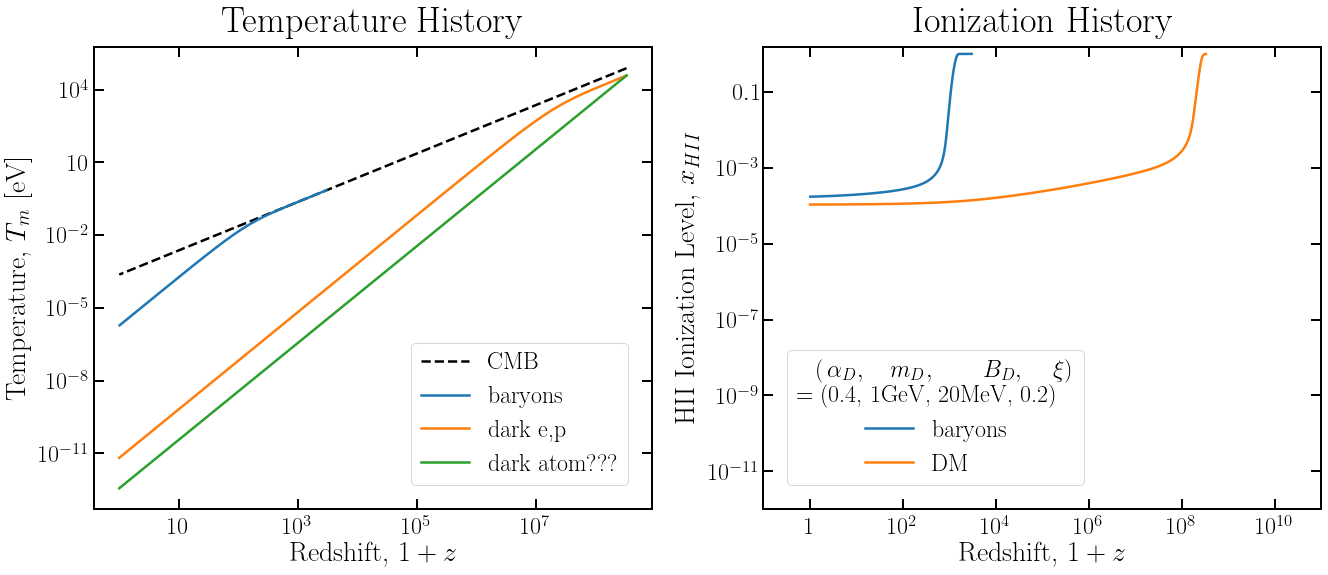

In [17]:
plt.figure(figsize=(22,8.5))

plt.subplot(1, 2, 1)
plt.plot(rs_list_DM, phys.TCMB(rs_list_DM), color='k', linestyle='--', label='CMB')
plt.plot(rs_list, history0[:,0], label='baryons')
plt.plot(rs_list_DM, dark_history[:,0], label='dark e,p')
plt.plot(rs_list_DM, dark_history[0,0]*(rs_list_DM/rs_list_DM[0])**2, label='dark atom???')
# plt.plot(Tm_hist_data[:,0]+1, Tm_hist_data[:,1], label='Cyr-Racine')
plt.xlabel(r'Redshift, $1+z$')
plt.ylabel(r'Temperature, $T_m$ [eV]')
plt.title('Temperature History')
plt.loglog()
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(rs_list, history0[:,1], label='baryons')
plt.plot(rs_list_DM, dark_history[:,1], label='DM')#, linestyle='--')
# plt.plot(xe_hist_data[:,0]+1, xe_hist_data[:,1], label='Cyr-Racine')
plt.axis([0.1,1e11, 1e-12,1.5])
plt.xlabel(r'Redshift, $1+z$')
plt.ylabel(r'HII Ionization Level, $x_{HII}$')
plt.title('Ionization History')
plt.loglog()
plt.xticks(10.0**np.arange(0,12,2))
plt.yticks(10.0**np.arange(-11,1,2))
leg = plt.legend(fontsize=24)
#leg.set_title(r'$\,(\, \alpha_D,\;\;\;$ $m_{\textbf{e}}, \qquad$ $m_{\textbf{p}}, \;\;\;\,$ $\xi$) \\='
leg.set_title(r'$\,(\, \alpha_D,\;\;\;$ $m_{D}, \qquad$ $B_D, \;\;\;\,$ $\xi$) \\='
           +' (0.4, 1GeV, 20MeV, 0.2)')
plt.setp(leg.get_title(),fontsize=24)
# plt.savefig('/Users/gregoryridgway/Dropbox (MIT)/Atomic DM/figs/mbe_mbp_30MeV_alphaD_4e-3_xi_2e-1.png')

### semi-analytic treatment -- Saha Equilibrium and Instantaneous Freeze-out

In [28]:
def xD_Saha(rs, me, mp, xi, B):
    T = phys.TCMB(rs)*xi
    mD = me + mp
    nD = phys.rho_DM/mD
    hplanck = 2*np.pi*phys.hbar
    #lambda_e = thermal_wavelength(me,T)
    #lambda_p = thermal_wavelength(mp,T)
    #lambda_H = thermal_wavelength(mH,T)
    rhs = (2*np.pi*me*mp*T/(hplanck**2*mD))**(3/2) / (nD*rs**3) * np.exp(-B/T) / phys.c**3
    a  = 1.
    b  = rhs
    q  = -rhs
    if rhs < 1e8:
        xe = (-b + np.sqrt(b**2 - 4*a*q))/(2*a)
    else:
        xe = 1. - a/rhs

    return xe

In [29]:
rs_bound = 5
xe_thresh = 0.5

# redshift of recombination is defined as the point at which xD = 0.5 +/- .05
def get_recomb_rs(alphaD, mD, xi, B):
    #mp = mp_D(mD, alphaD, B)
    #me = me_D(mD, alphaD, B)
    me = (mD+B)/2
    mp = (mD+B)/2
    rsLow = rs_bound
    rsHigh = 10*rsLow
    xD_low = xD_Saha(rsLow, me, mp, xi, B)
    
    # if recombination hasn't started by redshift rs_bound, then these parameters don't work
    if xD_low > .5:
        return (rs_bound, xD_low)
    else:
        xD_high = xD_Saha(rsHigh, me, mp, xi, B)
        #Now find a redshift at which recombination has not occured
        while(xD_high < .5):
            rsLow=rsHigh
            xD_low=xD_high
            
            rsHigh = 2*rsHigh
            xD_high = xD_Saha(rsHigh, me, mp, xi, B)
            
        #Now find the redshift of recombination
        while((np.abs(xD_low-0.5)>0.05) or (np.abs(xD_high-0.5)>0.05)):
            rsMid = rsHigh/2+rsLow/2
            xD_mid = xD_Saha(rsMid, me, mp, xi, B)
            if(xD_mid>0.5):
                rsHigh = rsMid
                xD_high = xD_mid
            else:
                rsLow = rsMid
                xD_low = xD_mid
        rsMid = rsHigh/2+rsLow/2
        return (rsMid, xD_Saha(rsMid, me, mp, xi, B))

In [30]:
def get_f(rs, mD, alpha, xi, B):
    # Assume T_DM = T_D
    n_DM = phys.rho_DM/mD * rs**3
    TD = phys.TCMB(rs)*xi
    mu = mu_D(alpha, B)
    return phys.hubble(rs)/(A_B(TD, B, mu, alpha) * n_DM)

In [31]:
mD = 6e7
alphaD = phys.alpha/5
BD = mD/(8/alphaD**2-1)
xi = .08
# if(mD/BD - 8/alphaD**2 <  - 1):
#     print('NOPE!', ' ', mD/BD - 8/alphaD**2)
tmp = get_recomb_rs(alphaD, mD, xi, BD)
rs_r = tmp[0]
print(tmp)
print(get_f(rs_r, mD, alphaD, xi, BD))

(24700.0, 0.5118559785515813)
0.0015790615023712348


In [32]:
mD = 6e7
xis = np.arange(.01,.805,.005)
alphas = np.arange(phys.alpha/10,2*phys.alpha,phys.alpha/40)
Bs = mD/(8/alphas**2-1)
tmp = [[get_recomb_rs(a, mD, xi, b)[0]
       for xi in xis] for a,b in zip(alphas,Bs)]
tmp2 = [[get_f(tmp[j][i], mD, a, xi, Bs[j])
       for i,xi in enumerate(xis)] for j,a in enumerate(alphas)]

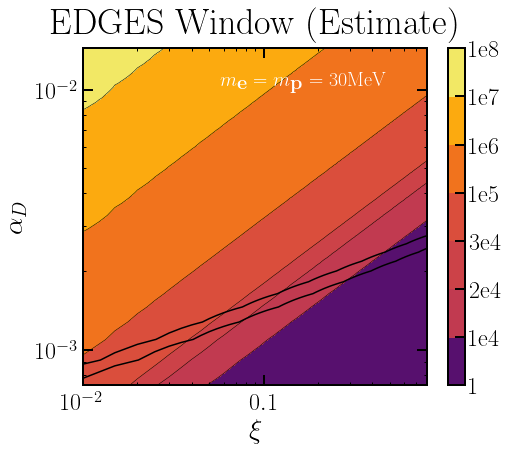

In [33]:
plt.figure(figsize=(7.7, 6.2))
ax = plt.gca()
ax.loglog()

# Specify the proper contour levels and label them
frac_change_levels = [1, 1e4,2e4, 3e4, 1e5, 1e6, 1e7, 1e8]
frac_change_labels = ['1', '1e4', '2e4', '3e4', '1e5', '1e6', '1e7', '1e8']        
    
    
plt_heating = plt.contour(
    xis, alphas, tmp,
    levels=frac_change_levels,
    linewidths=0.5,
    colors='k'
)


f_levels = [1.5e-3, 2.5e-3]
f_plt = plt.contour(
    xis, alphas, tmp2,
    levels=f_levels,
    linewidths=1.5,
    colors='k'
)

cntr1 = ax.contourf(xis, alphas, tmp, 
                    frac_change_levels,
                    norm=matplotlib.colors.LogNorm(),
                    cmap=matplotlib.cm.inferno
)

cbar = plt.colorbar(
    cntr1, ax=ax, ticks=frac_change_levels,
)
cbar.set_ticklabels(frac_change_labels)
# plt.plot(xis, xis**(.52)/95)
# plt.plot(xis, xis**(.26)/214)
# cbar.set_label(r'$T_m$ Fractional Change $\delta T_m/ T_{m,0}$', labelpad=20)

# plt.axis([xis[0], xis[-1], 5.1, 201.61653821924926])

label1_txt = r'$m_\textbf{e} = m_\textbf{p} = 30$MeV'
label2_txt = r'$B_D = m_D\left(\frac{8}{\alpha^2} - 1\right)^{-1}$'
label1_dx = .4
label2_dx = .407
                    
plt.text(label1_dx, 0.88, label1_txt,transform=ax.transAxes, color='w', fontsize=20)
# plt.text(label2_dx, 0.78, label2_txt,transform=ax.transAxes, color='w', fontsize=20)

plt.title(r'EDGES Window (Estimate)')
plt.xlabel(r'$\xi$')
plt.ylabel(r'$\alpha_D$')
# plt.savefig('/Users/gregoryridgway/Dropbox (MIT)/Atomic DM/alpha_xi_contours_mD30MeV.pdf')
plt.show()

In [34]:
mD = 3e7
alphaD = phys.alpha/3.7
BD = mD/(8/alphaD**2-1)
xi = .1
# if(mD/BD - 8/alphaD**2 <  - 1):
#     print('NOPE!', ' ', mD/BD - 8/alphaD**2)
tmp = get_recomb_rs(alphaD, mD, xi, BD)
rs_r = tmp[0]
print(tmp)
n_DM = phys.rho_DM/mD * rs_r**3

tmp = phys.hubble(rs_r)/(A_B(phys.TCMB(rs_r)*xi,BD,mu_D(alphaD, BD),alphaD) * n_DM)
print(tmp)

mD = 3e7
alphaD = phys.alpha/3.5
BD = mD/(8/alphaD**2-1)
xi = .12
# if(mD/BD - 8/alphaD**2 <  - 1):
#     print('NOPE!', ' ', mD/BD - 8/alphaD**2)
tmp = get_recomb_rs(alphaD, mD, xi, BD)
rs_r = tmp[0]
print(tmp)
# Assume T_DM = T_D
n_DM = phys.rho_DM/mD * rs_r**3

tmp = phys.hubble(rs_r)/(A_B(phys.TCMB(rs_r)*xi,BD,mu_D(alphaD, BD),alphaD) * n_DM)
print(tmp)

(18500.0, 0.49297883350637994)
0.0001505261968558826
(17100.0, 0.5161155570384329)
0.00014590234118415913


TypeError: xD_Saha() missing 1 required positional argument: 'B'

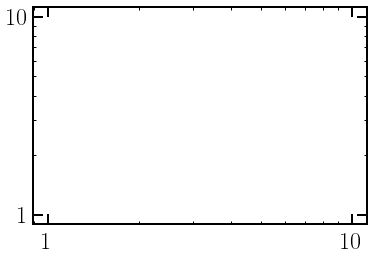

In [35]:
rs_list=np.arange(200,1e5,10)

plt.figure()
ax=plt.gca()
ax.loglog()
tmp = np.array([xD_Saha(rs, phys.me, phys.mp, phys.rydberg) for rs in rs_list])

#plt.axis([200,1e5,.9,1.1])
plt.axvline(1350)
plt.plot(rs_list, tmp)
plt.show()

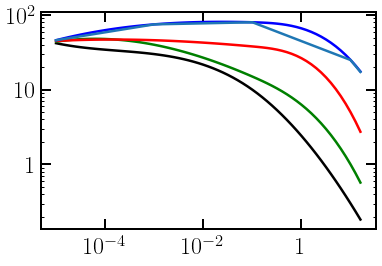

In [36]:
%autoreload
plt.figure()
ys1=np.array([42,30, 10, 0.3, 0.15])
ys2=np.array([44,40, 15, 1, 0.45])
ys3=np.array([45,46, 38, 5, 2.1])
ys4=np.array([46,75, 80, 25, 15])

xs=np.array([1e-5,1e-3,1e-1, 10, 19])
fine_xs = 10**np.arange(-5,np.log10(19),0.1)
colors = ['k', 'green', 'red', 'blue']

for i,ys in enumerate([ys1, ys2, ys3, ys4]):
    fine_ys = 10**interp1d(np.log10(xs), np.log10(ys), kind='cubic')(np.log10(fine_xs))
    plt.loglog()
    plt.plot(fine_xs,fine_ys, color=colors[i])
    
plt.plot(fine_xs, dark_tla.F_pr(fine_xs, 0.06))

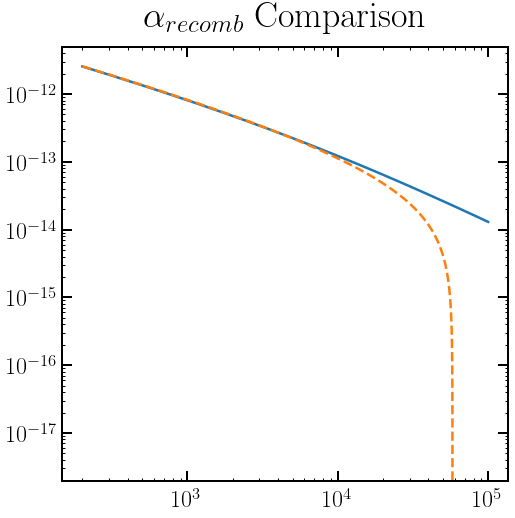

In [37]:
%autoreload
plt.figure(figsize=(8,8))
plt.title(r'$\alpha_{recomb}$ Comparison')

# plt.axis([.5, 5e3, 1e-13,1e-10])
plt.loglog()
plt.plot(rs_list,phys.alpha_recomb(phys.TCMB(rs_list), 'HI'))
plt.plot(rs_list,dark_tla.dark_alpha_recomb(phys.TCMB(rs_list), phys.alpha, phys.me, phys.mp, 1), linestyle='--')

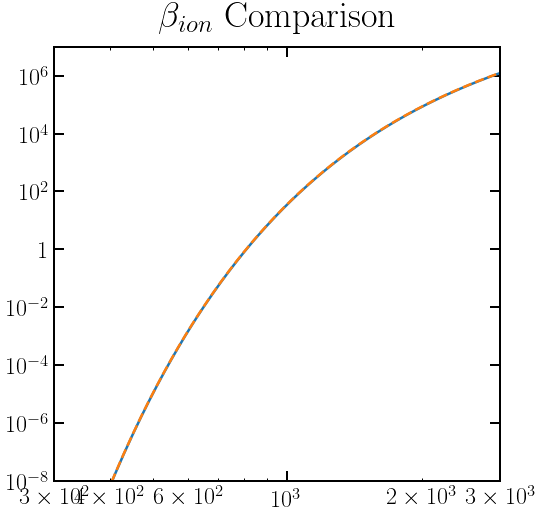

In [38]:
%autoreload
plt.figure(figsize=(8,8))
plt.title(r'$\beta_{ion}$ Comparison')

plt.loglog()

plt.axis([300,3e3,1e-8,1e7])
plt.plot(rs_list,phys.beta_ion(phys.TCMB(rs_list), 'HI'))
plt.plot(rs_list,dark_tla.dark_beta_ion(phys.TCMB(rs_list), phys.alpha, phys.me, phys.mp, 1),linestyle='--')

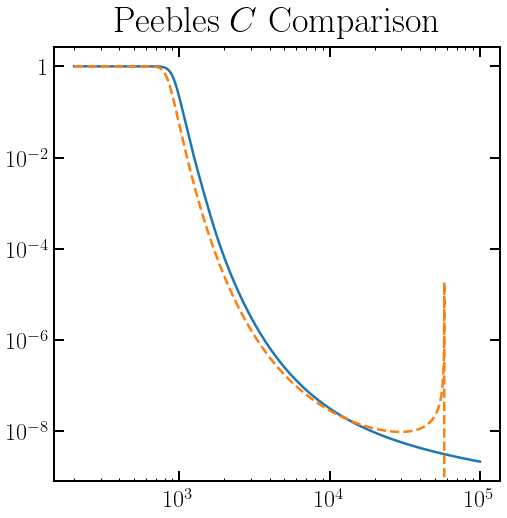

In [39]:
%autoreload
plt.figure(figsize=(8,8))
plt.title(r'Peebles $C$ Comparison')

plt.loglog()
plt.plot(rs_list,phys.peebles_C(.9, rs_list))
plt.plot(rs_list,dark_tla.dark_peebles_C(.9, rs_list, phys.alpha, phys.me, phys.mp, 1),linestyle='--')

In [40]:
import csv
xe_hist_data = []
with open('/Users/gregoryridgway/Desktop/Webplot Digitizer/Atomic/example_history.csv') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
         xe_hist_data.append([float(row[0]),float(row[1])])
xe_hist_data = np.array(xe_hist_data)

Tm_hist_data = []
with open('/Users/gregoryridgway/Desktop/Webplot Digitizer/Atomic/T_m_hist.csv') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
         Tm_hist_data.append([float(row[0]),float(row[1])])
Tm_hist_data = np.array(Tm_hist_data)

In [42]:
n_D = phys.rho_DM * rs_list_DM**3 / mD
Rayleighs=dark_tla.Pi_R(dark_history[:,1], dark_history[:,0], rs_list_DM, alphaD, m_be, m_bp, xi)/phys.hbar/(
    3/2*dark_history[:,1]*n_D*(1+dark_history[:,1]))

comps=dark_tla.compton_cooling_rate(dark_history[:,1], dark_history[:,0], rs_list_DM, alphaD, m_be, m_bp, xi)/(
    xi*phys.TCMB(rs_list_DM)-dark_history[:,1])

In [45]:
alphaD=0.4
xi=0.2
m_D = 1e9
B_D = 2e7
print(mp_D(m_D, alphaD, B_D), me_D(m_D, alphaD, B_D))
m_be= 438585716#3e7
m_bp = 581414284#m_be
print(dark_tla.get_BD(alphaD, m_be, m_bp)/B_D, (m_be+m_bp-dark_tla.get_BD(alphaD, m_be, m_bp))/m_D)

581414284.285429 438585715.71457106
1.0000000001598721 0.9999999999968026


In [46]:
%autoreload
alphaD = phys.alpha#3e-3
m_be= phys.me#3e7
m_bp = phys.mp#m_be
xi=1#0.6


#alpha_list = 10**np.arange(-3.2,-1.9,.089)
#xi_list = 10**np.arange(-2,0,.1)
m_be= 438585716#3e7
m_bp = 581414284#m_be
xi = 0.2#.2 #0.072 #.1
alphaD = 0.4#4e-3 #7e-4 #1e-3

rs_start = find_rs_start(alphaD, m_be, m_bp, xi)

rs_list_DM = 10**np.arange(np.log10(rs_start),0,-.001)
dark_history = dark_tla.get_history(
    rs_list_DM,
    alphaD=alphaD, m_be=m_be, m_bp=m_bp, xi=xi
)

[None, None]

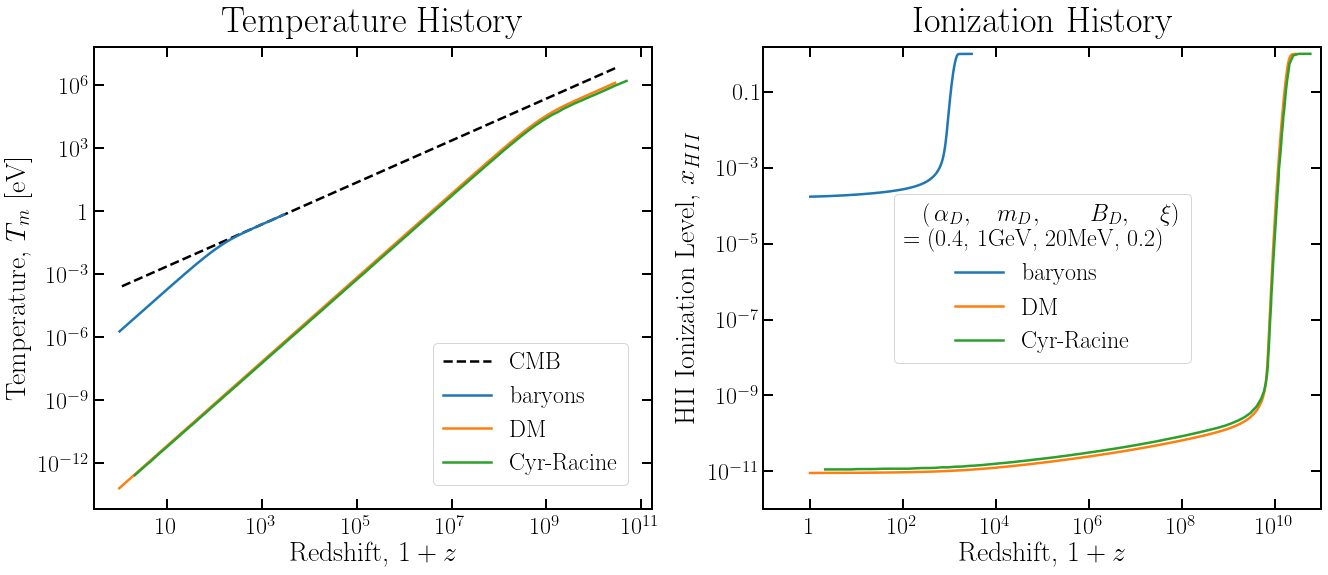

In [47]:
plt.figure(figsize=(22,8.5))

plt.subplot(1, 2, 1)
plt.plot(rs_list_DM, phys.TCMB(rs_list_DM), color='k', linestyle='--', label='CMB')
plt.plot(rs_list, history0[:,0], label='baryons')
plt.plot(rs_list_DM, dark_history[:,0], label='DM')
plt.plot(Tm_hist_data[:,0]+1, Tm_hist_data[:,1], label='Cyr-Racine')
plt.xlabel(r'Redshift, $1+z$')
plt.ylabel(r'Temperature, $T_m$ [eV]')
plt.title('Temperature History')
plt.loglog()
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(rs_list, history0[:,1], label='baryons')
plt.plot(rs_list_DM, dark_history[:,1], label='DM')#, linestyle='--')
plt.plot(xe_hist_data[:,0]+1, xe_hist_data[:,1], label='Cyr-Racine')
plt.axis([0.1,1e11, 1e-12,1.5])
plt.xlabel(r'Redshift, $1+z$')
plt.ylabel(r'HII Ionization Level, $x_{HII}$')
plt.title('Ionization History')
plt.loglog()
plt.xticks(10.0**np.arange(0,12,2))
plt.yticks(10.0**np.arange(-11,1,2))
leg = plt.legend(fontsize=24)
#leg.set_title(r'$\,(\, \alpha_D,\;\;\;$ $m_{\textbf{e}}, \qquad$ $m_{\textbf{p}}, \;\;\;\,$ $\xi$) \\='
leg.set_title(r'$\,(\, \alpha_D,\;\;\;$ $m_{D}, \qquad$ $B_D, \;\;\;\,$ $\xi$) \\='
           +' (0.4, 1GeV, 20MeV, 0.2)')
plt.setp(leg.get_title(),fontsize=24)
# plt.savefig('/Users/gregoryridgway/Dropbox (MIT)/Atomic DM/figs/mbe_mbp_30MeV_alphaD_4e-3_xi_2e-1.png')

In [48]:
n_D = phys.rho_DM * rs_list_DM**3 / m_D
T_DM = dark_history[:,0]
x_be = dark_history[:,1]
T_D = phys.TCMB(rs_list_DM)*xi
eps = 1-T_DM/T_D

comps = 1/phys.hbar*(1+(m_be/m_bp)**3)*64*np.pi**3*alphaD**2*(xi*phys.TCMB(rs_list_DM))**4/(135*m_be**3)*dark_history[:,1]/(1+dark_history[:,1])

In [49]:
zeta_9 = 1.00201

denom_fac = 3/2 * T_DM * n_D * (1+x_be)
Pi_R_overEps = 430080*zeta_9*alphaD**2 * n_D * (1-x_be)*(xi*phys.TCMB(rs_list_DM))**9/(
    np.pi**2 * B_D**4 * m_D * m_be**2
)/phys.hbar

Rayleighs = Pi_R_overEps/denom_fac

In [50]:
zeta_3 = 1.20206
muD = mu_D(alphaD, B_D)
g_ff = 1.3
Pi_ff_overEps = 16*alphaD**3*g_ff * np.sqrt(2*np.pi*T_DM) * x_be**2 * n_D**2/(3*muD)**(3/2)*(
    np.pi**2 * (1+2*eps)/6 - zeta_3*eps
)

Piffs = Pi_ff_overEps/denom_fac

In [51]:
Pi_pr_overEps = 2*alphaD**3*np.sqrt(2*np.pi*T_DM)/(3*muD)**(3/2)* x_be**2 * n_D**2*(
    dark_tla.F_pr(T_D/B_D, 1-eps)
)

Piprs = Pi_pr_overEps/denom_fac

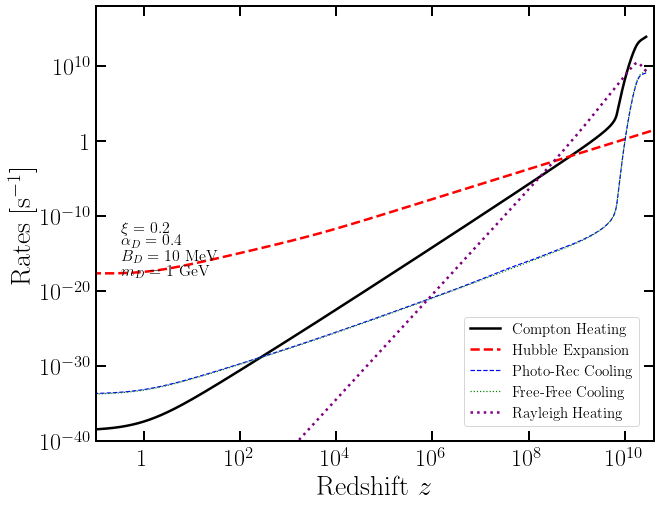

In [52]:
sub = 0.07
plt.figure(figsize=(10,8))
plt.loglog()
rs_list = 10**np.arange(0,np.log10(4e10),.1)
plt.axis([.1, 4e10, 1e-40,1e18])
plt.yticks(10.0**np.arange(-40,20,10))
plt.xticks(10.0**np.arange(0,12,2))

plt.plot(rs_list_DM-1, comps, color='k', label='Compton Heating')
plt.plot(rs_list-1, phys.hubble(rs_list), color='red', linestyle='--', label='Hubble Expansion')
plt.plot(rs_list_DM-1, Piprs, color='blue', linestyle='--', linewidth=1.2, label='Photo-Rec Cooling')
plt.plot(rs_list_DM-1, Piffs, color='g', linestyle=':', linewidth=1.2, label='Free-Free Cooling')
plt.plot(rs_list_DM-1, Rayleighs, color='purple', linestyle=':', label='Rayleigh Heating')

plt.ylabel(r'Rates [s$^{-1}$]')
plt.xlabel(r'Redshift $z$')

plt.text(0.2, 1.1, r'$\xi=0.2$', fontsize=16, transform=ax.transAxes)
plt.text(0.2, 1.1-sub, r'$\alpha_D=0.4$', fontsize=16, transform=ax.transAxes)
plt.text(0.2, 1.1-2*sub, r'$B_D=10$ MeV', fontsize=16, transform=ax.transAxes)
plt.text(0.2, 1.1-3*sub, r'$m_D=1$ GeV', fontsize=16, transform=ax.transAxes)

plt.legend(fontsize=15, loc=4)

In [607]:
def find_recomb_rs(x_be_func, alphaD, m_be, m_bp, xi, rs_guess):
    # I would to find the redshift at which x_e is between these two values
    lower_xe = .5-.01
    upper_xe = .5+.01

    # My initial guess for that redshift, and the x_e at that redshift
    rs = rs_guess
    x_be = x_be_func(rs)

    # Double or halve the redshift
    log_step = 2

    iterate=0
    while (x_be<lower_xe or x_be>upper_xe) and iterate < 50:
        iterate += 1
        if x_be<lower_xe:
            rs *= log_step
            x_be = x_be_func(rs)

            #overstepped the bounds
            if x_be>upper_xe:
                log_step -= np.log10(log_step)

        elif x_be>upper_xe:
            rs /= log_step
            x_be = x_be_func(rs)

            #overstepped the bounds
            if x_be<lower_xe:
                log_step -= np.log10(log_step)
        if iterate == 50:
            print('Too many iterations!!!')
#             print('redshift:', rs)
            print('x_be: ', x_be)
            print('xi', xi)
            print('alpha', alphaD)
#             print('iterations: ', iterate)
            

#     print('redshift:', rs)
#     print('x_be: ', x_be)
#     print('iterations: ', iterate)
    return rs

In [519]:
x_be_func = interp1d(rs_list_DM, dark_history[:,1], bounds_error=False, fill_value=(dark_history[-1,1],dark_history[0,1]))

In [496]:
find_recomb_rs(x_be_func, alphaD, m_be, m_bp, xi, rs_list_DM[0])

redshift: 1227.631281634815
x_be:  0.49785261297090866
iterations:  15


1227.631281634815

In [612]:
xe_data_3e7 = xe_data.copy()
recomb_rs_data_3e7 = recomb_rs_data.copy()

In [690]:
alpha_list = 10**np.arange(np.log10(7e-4),np.log10(2e-2),.03)
xi_list = 10**np.arange(np.log10(.01),np.log10(.8),.02)
m_be= 3e7
m_bp = m_be

xe_data = np.zeros((alpha_list.size, xi_list.size))
recomb_rs_data = np.zeros((alpha_list.size, xi_list.size))

for i,alphaD in enumerate(tqdm(alpha_list)):
    print('alphaD', alphaD)
    for j,xi in enumerate(tqdm(xi_list)):
        
        rs_start = find_rs_start(alphaD, m_be, m_bp, xi)
        rs_list_DM = 10**np.arange(np.log10(rs_start),np.log10(1+17.2),-.01)
        dark_history = dark_tla.get_history(
            rs_list_DM,
            alphaD=alphaD, m_be=m_be, m_bp=m_bp, xi=xi
        )
        
        if np.isnan(xe_data[-1,1]):
            print('BAD')
            xe_data[i,j] = 1e-12
            recomb_rs_data[i,j] = 1e-12
        else:
            xe_data[i,j] = dark_history[-1,1]

            x_be_func = interp1d(rs_list_DM, dark_history[:,1], bounds_error=False, fill_value=(dark_history[-1,1],dark_history[0,1]))
            recomb_rs_data[i,j] = find_recomb_rs(
                x_be_func, alphaD, m_be, m_bp, xi, rs_list_DM[0]
            )

alphaD 0.0007000000000000001


alphaD 0.0007500635136663244


alphaD 0.0008037075350478173


alphaD 0.0008611881395686661


alphaD 0.0009227797169894835


alphaD 0.000988776281235926


alphaD 0.001059492873905343


alphaD 0.0011352670681512476


alphaD 0.0012164605801245588


alphaD 0.0013034609956640022


alphaD 0.0013966836204782097


alphaD 0.0014965734626515555


alphaD 0.001603607356937433


alphaD 0.0017182962409795115


alphaD 0.0018411875943267562


alphaD 0.0019728680518851047


alphaD 0.0021139662042813966


alphaD 0.002265155598507381


alphaD 0.0024271579531677024


alphaD 0.0026007466036801863


alphaD 0.002786750193874456


alphaD 0.002986056631611121


alphaD 0.003199617327304094


alphaD 0.0034284517355790884


alphaD 0.003673652221748369


alphaD 0.0039363892763324


alphaD 0.0042179171025204555


alphaD 0.004519579603242535


alphaD 0.004842816796432495


alphaD 0.005189171689106356


alphaD 0.0055602976430698964


alphaD 0.005957966267416554


alphaD 0.006384075875491278


alphaD 0.006840660546690575


alphaD 0.0073298998363561865


alphaD 0.007854129180113622


alphaD 0.008415851042321756


alphaD 0.00901774686185179


alphaD 0.009662689852220031


alphaD 0.010353758717177272


alphaD 0.011094252347227596


alphaD 0.011887705567231994


alphaD 0.012737906010269646


alphaD 0.013648912198306056


alphaD 0.01462507291597799


alphaD 0.015671047969978064


alphaD 0.01679183043313609


alphaD 0.01799277047938167


alphaD 0.019279600923366752


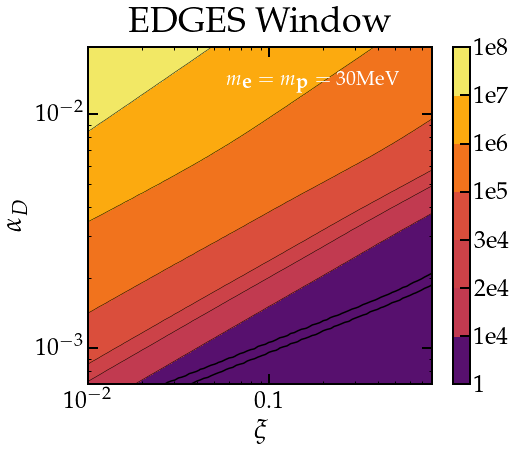

In [691]:
plt.figure(figsize=(7.7, 6.2))
ax = plt.gca()
ax.loglog()

# Specify the proper contour levels and label them
frac_change_levels = [1, 1e4,2e4, 3e4, 1e5, 1e6, 1e7, 1e8]
frac_change_labels = ['1', '1e4', '2e4', '3e4', '1e5', '1e6', '1e7', '1e8']        
    
    
plt_heating = plt.contour(
    xi_list, alpha_list, recomb_rs_data,
    levels=frac_change_levels,
    linewidths=0.5,
    colors='k'
)


f_levels = [1.5e-3, 2.5e-3]
f_plt = plt.contour(
    xi_list, alpha_list, xe_data,
    levels=f_levels,
    linewidths=1.5,
    colors='k'
)

cntr1 = ax.contourf(xi_list, alpha_list, recomb_rs_data, 
                    frac_change_levels,
                    norm=matplotlib.colors.LogNorm(),
                    cmap=matplotlib.cm.inferno
)

cbar = plt.colorbar(
    cntr1, ax=ax, ticks=frac_change_levels,
)
cbar.set_ticklabels(frac_change_labels)
# plt.plot(xis, xis**(.52)/95)
# plt.plot(xis, xis**(.26)/214)
# cbar.set_label(r'$T_m$ Fractional Change $\delta T_m/ T_{m,0}$', labelpad=20)

# plt.axis([xis[0], xis[-1], 5.1, 201.61653821924926])

label1_txt = r'$m_\textbf{e} = m_\textbf{p} = 30$MeV'
# label2_txt = r'$B_D = m_D\left(\frac{8}{\alpha^2} - 1\right)^{-1}$'
label1_dx = .4
label2_dx = .407
                    
plt.text(label1_dx, 0.88, label1_txt,transform=ax.transAxes, color='w', fontsize=20)
# plt.text(label2_dx, 0.78, label2_txt,transform=ax.transAxes, color='w', fontsize=20)

plt.title(r'EDGES Window')
plt.xlabel(r'$\xi$')
plt.ylabel(r'$\alpha_D$')
plt.savefig('/Users/gregoryridgway/Dropbox (MIT)/Atomic DM/alpha_xi_contours_mD30MeV_ODE_solve.pdf')
plt.show()

# Rates

In [26]:
# specify 4 unknowns
me = 3e7
mp = 3e7
alphaD=3e-3
xi=.1

# derived quantities
BD = ryd_D(me, mp, alphaD)
mD=me+mp-BD

In [21]:
#--- Rates ---#

#hubble
#phys.hubble

# dark e-p scattering rate, Coulomb
def ep_rate(rs):
    muD = me*mp/(me+mp)
    
    #assume DM is perfectly coupled to dark CMB
    TDM = phys.TCMB(rs) * xi
    
    
    lnL = np.log(TDM**(3/2))*(np.pi*nD*xD)**(-1/2)*(alphaD)**(-3/2)
    return np.sqrt(muD)*TDM**(3/2) / (np.sqrt(2*np.pi) * alphaD**2 * nD * xD * lnL)

2.290190051235983e+17

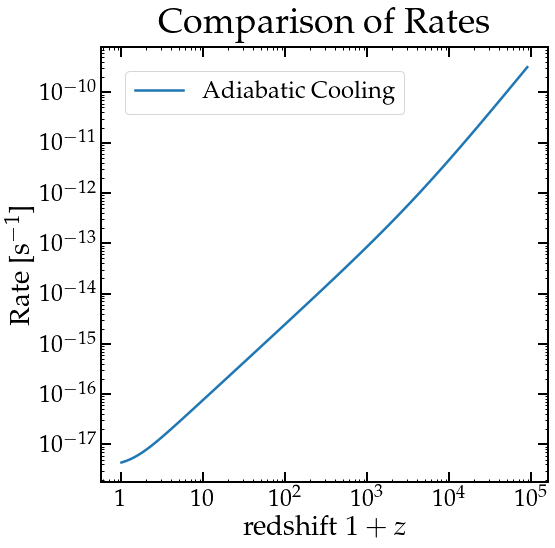

In [44]:
rs_vec = 10**np.arange(0,5,.05)
plt.figure(figsize=(8,8))
plt.loglog()

plt.plot(rs_vec, 2*phys.hubble(rs_vec), label='Adiabatic Cooling')

plt.title(r'Comparison of Rates')
plt.xlabel(r'redshift $1+z$')
plt.ylabel(r'Rate [s$^{-1}$]')
plt.legend()

plt.show()

## Structure Formation Constraints

In [7]:
Msol = 2e30 * 2e36
kF = np.sqrt(1e9/phys.TCMB(1))**(1/2)*phys.hubble(1)/phys.c
phys.rho_crit*(np.pi/kF)**3 * 4*np.pi/3/Msol/1e6  /1e8

1.3560772667898744

# Scratch

In [92]:
# Eq. (22)
# Assumes TD/BD ~ .007
def xD_approx(omega_D):
    return 2e-16*xi/(alphaD**6)*(.11/omega_D/phys.h**2)*(mD/GeV)*(BD/keV)

def thermal_wavelength(m, T):
    hplanck = 2*np.pi*phys.hbar
    return phys.c * hplanck / np.sqrt(2 * np.pi * m * T)

# Import Standard Solution

In [ ]:
std_soln = pickle.load(open('standard_soln.p','rb'))
std_soln_rs = std_soln[0]
std_soln_T = std_soln[1]
std_soln_xe = std_soln[2]

# Import 21cmFast

In [ ]:
a = np.loadtxt('../global_evolution_zetaIon30.00_Nsteps40_zprimestepfactor1.020_zetaX2.0e+56_alphaX1.2_TvirminX3.0e+04_Pop2_256_300Mpc')

#Big hydrodynamic simulation with structure formation, stars, and x-ray sources
redshift = a[:,0]
filling_fac_HI = a[:,1]
T_m = a[:,2]
xe = a[:,3]
T_S = a[:,4]
T_CMB = a[:,5]
J_alpha = a[:,6]
x_alpha = a[:,7]
dT_Xray_dz_raw = a[:,8]
dxe_Xray_dz_raw = a[:,9]

In [ ]:
def get_T_21(xe, T_R, T_S, z):
    xHI = 1 - xe
    return (
        xHI*np.sqrt(0.15/phys.omega_m)
        * phys.omega_baryon*phys.h/0.02
        * np.sqrt((1+z)/10)
        * (1 - (T_R/T_S))
        * 23*1e-3
    )

T_21 = get_T_21(xe, T_CMB, T_S, redshift)

### Spin Temperature

In [ ]:
# Temperatures in K, Rates in cm^3 s^-1

T_HH_raw_below_300K = np.array(
    [1, 2, 4, 6, 8, 10, 15, 20, 25, 30, 
     40, 50, 60, 70, 80, 90, 100, 200, 300]
)
kappa_HH_raw_below_300K = np.array(
    [1.38, 1.43, 2.71, 6.60, 14.7, 28.8, 91., 178., 273., 
     367., 538., 686., 814., 925., 1020., 1110., 1190., 1750., 2090.]
)*1e-13

T_eH_raw = np.array(
    [1, 2, 5, 10, 20, 50, 1000, 200, 500, 1000, 
     2000, 3000, 5000, 7000, 10000, 15000, 20000]
)
kappa_eH_raw = np.array(
    [0.239, 0.337, 0.530, 0.746, 1.05, 1.63, 2.26, 3.11, 
    4.59, 5.92, 7.15, 7.71, 8.17, 8.32, 8.37, 8.29, 8.11]
)*1e-9

T_pH_raw = T_eH_raw

kappa_pH_raw = np.array(
    [0.4028, 0.4517, 0.4301, 0.3699, 0.3172, 0.3047, 0.3379, 
     0.4043, 0.5471, 0.7051, 0.9167, 1.070,  1.301,  1.480, 
     1.695,  1.975,  2.201]
)*1e-9

def x_c(T_m, T_CMB, xe, rs):
    
    def kappa_HH(T_matter):
        rates = np.zeros_like(T_matter)
        
        T_matter_low  = T_matter[T_matter <= 300]
        T_matter_high = T_matter[T_matter > 300]
        
        rates[T_matter <= 300] = np.interp(T_matter_low, T_HH_raw_below_300K, kappa_HH_raw_below_300K)
        rates[T_matter >= 300] = 8.652e-11 * T_matter_high**0.2067 * np.exp(-87.56/T_matter_high)
        
        return rates

    kappa_HH_rates = kappa_HH(T_m)
    kappa_eH_rates = np.interp(T_m, T_eH_raw, kappa_eH_raw)
    kappa_pH_rates = np.interp(T_m, T_pH_raw, kappa_pH_raw)
    
    nHI = (1 - xe)*phys.nH*rs**3
    ne  = xe*phys.nH*rs**3
    nprotons  = xe*phys.nH*rs**3
    
    return 0.0628/(2.85e-15 * T_CMB)*(nHI*kappa_HH_rates + ne*kappa_eH_rates + nprotons*kappa_pH_rates)

In [ ]:
x_c_arr = x_c(T_m, T_CMB, xe, 1+redshift)
T_S_from_x_alpha = 1/((1/T_CMB + (x_alpha + x_c_arr)*(1/T_m))/(1 + x_alpha + x_c_arr))

# Structure Formation

Roughly following Diamanti et al. (1308.2578), 
we find that structure formation leads to a halo boost factor given by

\begin{equation}
    G_p(z) = \frac1{\rho_{\chi,0}^2 (1+z)^6} \int dM \frac{dn}{dM}(M,z) \
    \int_0^{r_\Delta} dr \; 4 \pi r^2 \; \langle v^2(r)\rangle \rho^2_{Halo}(r)
\end{equation}

where $\langle \sigma v \rangle =  (\sigma v)_{ref} \frac{\langle v^2(r) \rangle}{v^2_{ref}}$. 

As a first pass, we will use an NFW profile

\begin{equation}
    \rho_{Halo}(r) = \rho_s \frac{4}{(r/r_s)(1 + r/rs)^2}
\end{equation}

for which the r integral above has a closed form solution.
Notice, we have included the factor of 4 in the NFW that Diamanti and Prada use.
We will need the concentration parameter, $c = \frac{r_\Delta}{rs}$,
a function of halo mass and redshift to make headway.

### Calculation of c(M,z)

The following definitions and equations come from 1104.5130

In [ ]:
from scipy.integrate import quad
import numpy as np

rs_list = np.arange(1,1000.1,.05)

omega_lambda = .726
omega_m = 1-omega_lambda

# Eq. 13
def x_frac(a):
    return (omega_lambda/omega_m)**(1/3) * a

# For Eq. 12
def integrand(x):
     return (x/(1 + x**3))**(3/2)
    
x_list = np.array([x_frac(1/rs) for rs in rs_list])
D_list = [quad(integrand, 0, x)[0] for x in x_list]
D_interp = scipy.interpolate.interp1d(
    x_list, D_list
)
    
const = 5/2 * (omega_m/omega_lambda)**(1/3) * (
    np.sqrt(1 + x_list[0]**3) / x_list[0]**(3/2) * D_interp(x_list[0])
)

# Eq. 12, added a normalization const to ensure D(1) = 1 as they said in the text
def D(a):
    x = x_frac(a)
    return 5/2 * (omega_m/omega_lambda)**(1/3) * (
        np.sqrt(1 + x**3) / x**(3/2) * D_interp(x)/const
    )

In [ ]:
#Eq. 23
def sigma(M_tilde, a):
    #Make sure M is in units of M_sun * h^-1
    y = 10**12 / M_tilde
    return D(a) * 16.9 * y**0.41 / (1 + 1.102 * y**0.20 + 6.22 * y**0.333)

#Eq. 21
c0 =    3.681
c1 =    5.033
alpha = 6.948
x_0 =   0.424

#Eq. 19
def c_min(x):
    return c0 + (c1 - c0) * (
        np.arctan(alpha*(x-x_0))/np.pi + .5
    )

#Eq. 22
sig_inv0 = 1.047
sig_inv1 = 1.646
beta =     7.386
x_1 =      0.526

#Eq. 20
def sig_inv_min(x):
    return sig_inv0 + (sig_inv1 - sig_inv0) * (
        np.arctan(beta*(x-x_1))/np.pi + .5
    )

#Eq. 18, enforced B0 = B1 = 1 at a = 1
def B0(x):
    return c_min(x)/c_min(x_frac(1))
def B1(x):
    return sig_inv_min(x)/sig_inv_min(x_frac(1))

In [ ]:
#Eq. 15
def sig_p(M,a):
    return B1(x_frac(a)) * sigma(M,a)

#Eq. 17
A_param = 2.881
b_param = 1.257
c_param = 1.022
d_param = 0.060

#Eq. 16
def lnC(sigp):
    return np.log(A_param*((sigp/b_param)**c_param + 1)) + (d_param/sigp**2)

#Eq. 14, The bottom line
def lnc(M,z):
    return np.log(B0(x_frac(1/(1+z)))) + lnC(sig_p(M,1/(1+z)))

In [ ]:
Ms = 10**np.arange(11,15,.1)

plt.figure(figsize=(10,10))

ax = plt.gca()

logc_plt0, = plt.plot(np.log10(Ms), np.array([np.log10(2.718281) * lnc(M, 0) for M in Ms]))

logc_pltp5, = plt.plot(np.log10(Ms), np.array([np.log10(2.718281) * lnc(M, .5) for M in Ms]))

logc_plt1, = plt.plot(np.log10(Ms[:-4]), np.array([np.log10(2.718281) * lnc(M, 1) for M in Ms[:-4]]))

logc_plt2, = plt.plot(np.log10(Ms[:-10]), np.array([np.log10(2.718281) * lnc(M, 2) for M in Ms[:-10]]))

plt.title(r'\bf{Concentration parameter vs. Halo Mass}')
plt.xlabel(r'log $M_{200}$ ($M_\odot \, h^{-1}$)')
plt.ylabel('log c')
plt.axis([10, 15, .5, 1])

plt.show()

Eq. B10 (which has an extra factor of $r^2$ in it) and Fig. 5 of Diamanti give a more convenient expression for $G_p(z)$

\begin{equation}
    G_p(z) = \frac1{\rho_{\chi,0}^2 (1+z)^6} \int dM \frac{dn}{dM}(M,z) \; G r_s^5 \rho_s^3 \; I(c)
\end{equation}
with
\begin{equation}
    I(c) = \frac1{G \rho_s^3 r_s^5} \
    \int_0^{r_\Delta} dr \; (4 \pi r^2) \
    \left(3 \langle \Sigma^2(r) \rangle \right) \
    \rho^2(r)
\end{equation}
which we determine below

In [ ]:
import csv
length = 74
width = 2
datums = np.zeros([length,width])
# with open('/Users/gridgway/Desktop/WebplotDigitizer/'+
#           'pwave Boost/I_integral.csv') as csvfile:
#     reader = csv.reader(csvfile, delimiter= ',')
#     for k,row in enumerate(reader):
#         datums[k,:] = [np.log10(float(r)) for r in row]

#!!! Compute this right here, don't import it
with open('/Users/gridgway/Desktop/DarkHistory/I_integral.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter= ',')
    for k,row in enumerate(reader):
        datums[k,:] = [np.log10(float(r)) for r in row]
        
logI_interp = scipy.interpolate.interp1d(
    datums[:,0], datums[:,1], bounds_error=False, fill_value=(datums[0,1],datums[-1,1])
)
temp=np.arange(-3,1.1,0.1)

ax = plt.gca()
ax.set_xscale('log')

temp_plt, = plt.plot(10**temp, 10**logI_interp(temp))

plt.show()

Finally, we need $\rho_s$ and $r_s$ as functions of M and z.  Prada et al. use a virial radius with $\Delta = 200$, 
\begin{equation}
    r_\Delta = \left(
        \frac{M}{\frac{4}{3}\pi \, (200 \, \rho_c(z))}
    \right)^{\frac1{3}}
\end{equation}

Combining this with $M$ and $z$, we then have $r_s = r_\Delta / c$. 

To determine $\rho_s$, we use

\begin{equation}
    M = \int_0^{r_\Delta} dr \; 4 \pi r^2 \; \rho_{Halo}(r) = \int_0^{r_\Delta} dr \; 4 \pi r^2 \; \
    \rho_s \frac{4}{(r/r_s)(1 + r/rs)^2} = 16\pi \rho_s r_s^3 \left(-1 + \frac1{1 + c} + \ln(1 + c) \right)
\end{equation}

\begin{equation}
    \implies \rho_s = M \left(16\pi r_s^3 \left(\ln(1 + c) - \frac{c}{1 + c} \right) \right)^{-1}
\end{equation}

### Diamanti's Treatment

In [ ]:
#import hmf
logMmin = 6
logMmax = 15
log_step = .01
logMs_per_h = np.arange(logMmin,logMmax+log_step,log_step)

h = hmf.MassFunction(
    z=0.0, Mmin=logMmin, Mmax=logMmax, dlog10m=log_step, hmf_model="SMT"
)
Mpsc = 3.08567758149137 * 10**22 * 100

#G = 6.70711 * 10**-39 * phys.hbar * phys.c**5 * 10**-18 #PDG value of G in eV
G = 6.6726*10**-11 * Msol * 10**6 # m^3 / kg s^2 becomes cm^3 / M_sol s^2
rho_crit = 3 * phys.H0**2 / 8 / np.pi / G # critical density in solar mass units

Delta = 200

Ms = 10**logMs_per_h * phys.h # in Msol
dMs = Ms[1:] - Ms[:-1]

Ms = Ms[:-1]
logMs_per_h = logMs_per_h[:-1]

G_ps_cut = np.zeros_like(rs_list)
G_ps = np.zeros_like(rs_list)

for k,rs in enumerate(rs_list[:1600]):
    #mindex = np.searchsorted(Ms,interp_Mcuts(rs)-.01) #minimum mass index
    #mindex = np.searchsorted(Ms,5*10**10)
#     if k%10==0:
#         print(mindex)
    h.update(z=rs-1)
    rDel = (Ms / (4/3 * np.pi * Delta * rho_crit))**(1/3) * 1/rs
    logcs = np.log10(2.718281) * lnc(10**logMs_per_h, rs-1)
    Is = 10**logI_interp(logcs)
    ln_r_s = np.log(rDel) - np.log(10) * logcs
    ln_rho_s = np.log(Ms) - 3*ln_r_s - np.log(16 * np.pi) - np.log(np.log(1 + 10**logcs) - 
                                            10**logcs/(1+10**logcs))

#     G_ps_cut[k] = G /(phys.omega_DM**2 * rho_crit**2 * rs**6) * sum(
#         (np.exp((5*ln_r_s + 3*np.nan_to_num(ln_rho_s) + np.log(h.dndm/phys.h**4) - 3*np.log(Mpsc))) * dMs * Is)[mindex:]
#     )
    G_ps[k] = G /(phys.omega_DM**2 * rho_crit**2 * rs**6) * sum(
        (np.exp((5*ln_r_s + 3*np.nan_to_num(ln_rho_s) + np.log(h.dndm/phys.h**4) - 3*np.log(Mpsc))) * dMs * Is)
    )
    if np.isnan(G_ps[k]):
        print("You done goofed!!!")
        break

print(G_ps[:80])

### Jesus' Treatment

The above boost factor is about an order of magnitude off of Jesus', so we reproduce his by replacing $\langle \Sigma^2(r) \rangle$ by $v_{max}^2/3$, which is provided in Prada as well.  More specifically,

\begin{equation}
    \begin{split}
        B_p(z) & = \frac1{\rho_{\chi}^2(z) \sigma_{1D}^2(z)} \int dM \frac{dn}{dM}(M,z) \
        \int_0^{r_\Delta} dr \; 4 \pi r^2 \; \langle v^2(r)\rangle \rho^2_{Halo}(r)
        \\
        &= \frac{4 \pi \rho_s^2 r_s^3}{\rho_{\chi}^2(z) \sigma_{1D}^2(z)} \int dM \frac{dn}{dM}(M,z) \
        v_{max}^2 \left( 1 - \frac1{1+c^3}\right)
    \end{split}
\end{equation}

[\\]: <> (The above boost factor is about an order of magnitude off of Jesus', so we reproduce his to identify the discrepancy.  The relevant formula is given in Eqn. 15 
\begin{equation}
    \mathcal{B}(z) = \
    \frac{\Delta}{\Omega^2_m \rho_{crit}(z)} \
    \int_{M_{min}}^\infty \, M B_h(M,z) \frac{dn}{dM}(M,z) dM
\end{equation}
)

[\\]: <> (where, for an NFW profile, Eqn. 14 of _Taylor and Silk, Mon. Not. R. Astron. Soc. 339, 505–514 2003_ gives
\begin{equation}
    B_h(M,z) = \frac1{\overline{\rho}^2 V} \int_0^{r_\Delta} \rho^2(r) \; 4\pi r^2 dr \
    = \frac{c^3 \left(1-1/(1+c)^3\right)}{9\left[\ln(1+c) - c/(1+c) \right]^2}
\end{equation}
)

[\\]: <> (where c = c M,z is the concentration parameter that has already been calculated above.)

In [ ]:
#import hmf
logMmin = 6
logMmax = 15
log_step = .01
logMs_per_h = np.arange(logMmin,logMmax+log_step,log_step)

h = hmf.MassFunction(
    z=0.0, Mmin=logMmin, Mmax=logMmax, dlog10m=log_step, hmf_model="SMT"
)
Mpsc = 3.08567758149137 * 10**22 * 100

G = 6.6726*10**-11 * Msol * 10**6 # m^3 / kg s^2 becomes cm^3 / M_sol s^s
rho_crit = 3 * phys.H0**2 / 8 / np.pi / G # critical density in solar mass units

Delta = 200

#dMs = Ms * (np.arange(step,logMmax-logMmin+step,step))
Ms = 10**logMs_per_h * phys.h # in Msol
dMs = Ms[1:] - Ms[:-1]

Ms = Ms[:-1]
logMs_per_h = logMs_per_h[:-1]

#G_ps_cut = np.zeros_like(rs_list)
B_ps = np.zeros_like(rs_list)

for k,rs in enumerate(rs_list[:1600]):
    #mindex = np.searchsorted(Ms,interp_Mcuts(rs)-.01) #minimum mass index
    #if k%10==0:
    #    print(mindex)
    h.update(z=rs-1)
    logcs = np.log10(2.718281) * lnc(10**logMs_per_h, rs-1)
    cs = np.exp(lnc(Ms,rs-1))
    f_cs = np.log(1 + cs) - cs/(1+cs) #Prada, eq. 10
    
    rDel = (Ms / (4/3 * np.pi * Delta * rho_crit))**(1/3) * 1/rs
    v200 = np.sqrt(G * Ms / rDel)
    ln_v_max = .5 * np.log(.216 * cs / f_cs) + np.log(v200)
    #ln_v_max = np.log(4.74)
    
    ln_r_s = np.log(rDel) - np.log(10) * logcs
    ln_rho_s = np.log(Ms) - 3*ln_r_s - np.log(16 * np.pi) - np.log(f_cs)
    
    B_ps[k] = 64/3 * np.pi /(phys.omega_DM**2 * rho_crit**2 * sigma_1D_B**2 * rs**8) * sum(
        (np.exp(
            (3*ln_r_s + np.nan_to_num(2*ln_rho_s + 2*ln_v_max) + np.log(h.dndm/phys.h**4) - 3*np.log(Mpsc))
        ) * dMs * (1 - 1/(1+cs)**3))
    )
    if np.isnan(B_ps[k]):
        print("You done goofed!!!")
        break

print(B_ps[:80])

In [ ]:
sigma_1D_B = 1e-11*phys.c*(1/100)**0.5

rho_ana = phys.rho_DM * rs_list**4 * sigma_1D_B/phys.c

# Diamanti's boost factor
rho_v_c_eff_Diamanti = phys.rho_DM * rs_list**4 * sigma_1D_B / phys.c * np.sqrt(
    1  + G_ps/sigma_1D_B**2 / rs_list**2)
# rho_v_c_eff_Diamanti_cut = phys.rho_DM * rs_list**4 * sigma_1D_B / phys.c * np.sqrt(
#     1  + G_ps_cut/sigma_1D_B**2 / rs_list**2)

# Jesus' boost factor
rho_v_c_eff_Jesus = phys.rho_DM * rs_list**4 * sigma_1D_B / phys.c * np.sqrt(
    1  + B_ps)

In [ ]:
# import csv
# length = 83
# width = 2
# datums = np.zeros([length,width])
# with open('/Users/gridgway/Desktop/WebplotDigitizer/rho_eff_Jesus/rho_eff_Jesus.csv') as csvfile:
#     reader = csv.reader(csvfile, delimiter= ',')
#     for k,row in enumerate(reader):
#         datums[k,:] = [float(r) for r in row]
        
NFW_subs_data = []
with open('/Users/gridgway/Dropbox (MIT)/21cm_pwave/math/data/rho_eff_NFW_subs_pwave.txt') as f:
    for line in f:
        inner_list = [float(num.strip()) for num in line.split(' ') if num]
        NFW_subs_data.append(inner_list)
        
NFW_subs_data = np.array(NFW_subs_data)
NFW_subs_data[:,2] *= .839418
NFW_subs_data[:,0] += 1
NFW_subs_data[:,1] = phys.rho_DM * NFW_subs_data[:,0]**4 * 10**-9 * sigma_1D_B/phys.c

In [ ]:
long_struct = rho_ana*10**-9
long_struct[rs_list<76.00001] = np.interp(
    rs_list[rs_list<76.00001],
    NFW_subs_data[:,0],
    NFW_subs_data[:,2]
)

print(long_struct)

In [ ]:
boost_v = np.sqrt(3*soln[:,1]/mDM) * phys.c / (sigma_1D_B * rs_vec)
boost_v = np.interp(
    rs_list,
    np.flipud(rs_vec),
    np.flipud(boost_v)
)

print(boost_v)

In [ ]:
rs_list

In [ ]:
phys.rho_DM * rs_list**4 * sigma_1D_B / phys.c * boost_v * 10**-9

In [ ]:
plt.figure(figsize=(10,10))

ax = plt.gca()

plt_rho_ana, = plt.plot(rs_list-1, rho_ana*10**-9 , color='black')

#plt_rho_eff_Jesus, = plt.plot(rs_list-1, rho_v_c_eff_Jesus*10**-9, color='C4', label = r'Greg\'s Jesus')
#plt_rho_eff_NFW, = plt.plot(NFW_subs_data[:,0]-1, NFW_subs_data[:,2], color='C3', label = r'Original Jesus')
#plt_rho_eff_NFW, = plt.plot(rs_list-1, long_struct, color='C3', label = r'Original Jesus')
plt_rho_v_c_eff_Diamanti, = plt.plot(rs_list-1, rho_v_c_eff_Diamanti*10**-9 , color='C3', label = r'Diamanti')

# more_boost = long_struct + phys.rho_DM * rs_list**4 * sigma_1D_B / phys.c * boost_v * 10**-9
more_boost = rho_v_c_eff_Diamanti*10**-9 + phys.rho_DM * rs_list**4 * sigma_1D_B / phys.c * boost_v * 10**-9
plt_rho_eff_v_boost, = plt.plot(rs_list-1, more_boost, color='C4')


# plt_cut, = plt.plot(rs_list-1, rho_v_c_eff_Diamanti_cut*10**-9 , color='C5', label = r'cut')

ax.set_xscale('log')
ax.set_yscale('log')

# leg2 = plt.legend(
#     [plt_rho_ana, plt_rho_v_c_eff_Diamanti, plt_rho_eff_NFW, plt_rho_eff_Jesus],#, plt_cut], 
#     ('Smooth', 'Diamanti', 'Original Jesus', 'Jesus'),#, 'cut'), 
#     loc=3, title=r'$f_{\chi,\mathrm{int}},$ $m_\chi = 0.01$, '+str(mDM/1e6)+'MeV'
# )
leg2 = plt.legend(
    [plt_rho_ana, plt_rho_v_c_eff_Diamanti, plt_rho_eff_v_boost],#, plt_cut], 
    ('Smooth', 'Clustered', 'Velocity Boost'),#, 'cut'), 
    loc=4
)

plt.setp(leg2.get_title(),fontsize=28)

#plt.gca().add_artist(leg)

#plt.title(r'\bf{Structure Formation boost}')
plt.ylabel(r'($\rho$ v/c)$_{eff}$ (GeV/cm$^{-3}$)')
plt.xlabel('z')
plt.axis([.1, 1e3, 1e-18, 2e-2])
plt.savefig('/Users/'+user+'/Dropbox (MIT)/21cm_pwave/plots/Cooling/pwave_structFormation_v_boost.pdf')
#plt.savefig('/Users/'+user+'/Dropbox (MIT)/21cm_pwave/plots/Cooling/Struct_Form_Boost_comparison.pdf')

plt.show()



In [ ]:
print((np.log10(f('H_ion',log10eng[4],10**log10rsOut[5]-1))+
 np.log10(f('H_ion',log10eng[5],10**log10rsOut[5]-1)))/2)

print(np.log10(f('H_ion',(log10eng[4]+log10eng[5])/2,10**log10rsOut[5]-1)))

# Compute $f_c(z)$'s

Normally we must use Eqn. (42) of Hongwan_OG

$$ f_c(z) = \frac{H(z)}{(1+z)^{\alpha-3}} \
\int \frac{(1+z')^{\alpha-4}}{H(z')} T_c(z',z'E) [1+B_p(z')] dz' $$

but for the absurd 12eV model I'm considering, injected photons are deposited instantaneously

$$ f(z) = 1 \text{ if excitation}, 0 \text{ otherwise} $$





### Load in $T_c(E, z_{out}, z_{out})$

In [ ]:
user = 'gridgway'
greg = ''
species='elec'

if species == 'elec':
    T_kji = np.loadtxt('/Users/'+user+'/Desktop/StructureFormation_data/transFunc_electron.dat', delimiter=',')
    mass_sub = phys.me
else:
    T_kji = np.loadtxt('/Users/'+user+'/Desktop/StructureFormation_data/transFunc_photon.dat', delimiter=',')
    mass_sub = 0

binStep = 40*70*70;

log10rsIn  = T_kji[0:70, 2]
log10rsOut = T_kji[0:70*70:70, 1] 
log10eng = T_kji[0:binStep:70*70, 0] 

T_kji = {
    'H_ion':   np.reshape(T_kji[0:binStep,3], (40,70,70)),
    'He_ion':  np.reshape(T_kji[binStep:2*binStep,3], (40,70,70)),
    'H_exc':   np.reshape(T_kji[2*binStep:3*binStep,3], (40,70,70)),
    'heating': np.reshape(T_kji[3*binStep:4*binStep,3], (40,70,70)),
    'cont':    np.reshape(T_kji[4*binStep:5*binStep,3], (40,70,70)) 
}
#index 1: channel
#index 2: energy 
#index 3: output rs
#index 4: input rs

In [ ]:
eng0  = 1
zOut = 67
zIn  = 68

print(T_kji['H_ion'][eng0,zOut,zIn])
print(T_kji['He_ion'][eng0,zOut,zIn])
print(T_kji['H_exc'][eng0,zOut,zIn])
print(T_kji['heating'][eng0,zOut,zIn])
print(T_kji['cont'][eng0,zOut,zIn])

### Compute $B_p(z')$

In [ ]:
#halo_boost_raw = (rho_v_c_eff_Diamanti_cut/rho_ana)**2
halo_boost_raw = (NFW_subs_data[:,2]/NFW_subs_data[:,1])**2

halo_boost = 10**np.flipud(np.interp(
#    np.flipud(rs_vec), rs_list, halo_boost_raw
    np.flipud(rs_vec), NFW_subs_data[:,0], np.log10(halo_boost_raw)
))

#Defined as in the Mathematica notebook
Bps = (10**np.interp(
#    10**log10rsIn, rs_list, halo_boost_raw
    10**log10rsIn, NFW_subs_data[:,0], np.log10(NFW_subs_data[:,2])
))**2/(phys.rho_DM * (10**log10rsIn)**4 * 10**-9 * sigma_1D_B / phys.c)**2

boost_v = np.ones_like(Bps)
#boost_v = np.sqrt(3*soln[:,1]/mDM) * phys.c / (sigma_1D_B * rs_vec)
# boost_v = (10**np.interp(10**log10rsIn, np.flipud(rs_vec), np.flipud(np.log10(boost_v))))**2

#Bps[log10rsIn > np.log10(NFW_subs_data[-1,0])] = 1

np.log10(halo_boost[(rs_vec < 25) * (20 < rs_vec)])

In [ ]:
print((np.log10(f('H_ion',log10eng[4],10**log10rsOut[5]-1))+
 np.log10(f('H_ion',log10eng[5],10**log10rsOut[5]-1)))/2)

print(np.log10(f('H_ion',(log10eng[4]+log10eng[5])/2,10**log10rsOut[5]-1)))

### Fold $T_c(E, z_{out}, z_{out})$ and  $B_p(z')$ together to make $\;f_c(z')$

In [ ]:
#!!! Remember to check for other type of extrapolation
#!!! Check inds_In case if z_dep exactly aligns with an injection redshift.
#!!! you're doing linear interpolation incorrectly

#Neighbor interpolation
def log10f_N(chan, log10E, log10rs, mindex):
    #mindex = 1 if I want the neighbor with the minimum index, 0 if maximum
    E_extrap = False
    z_extrap = False
    epsilon = 1e-12
    
    #Finding Indices
    inds_In = [True for i in np.arange(len(log10rsIn))]
    #inds_In[np.searchsorted(inds_In, True) - 1] = True
        
    ind_E = np.searchsorted(log10eng, log10E+epsilon) - mindex[0]
    if ind_E < 0:
        E_extrap = True
        ind_E = 0
    elif ind_E == len(log10eng) - mindex[0]:
        E_extrap = True
        ind_E = len(log10eng) - 1
        
    ind_dep = np.searchsorted(log10rsOut, log10rs+epsilon) - mindex[1]
    if ind_dep < 0:
        z_extrap = True
        ind_dep = 0
    elif ind_dep == len(log10rsOut) - mindex[1]:
        z_extrap = True
        ind_dep = len(log10rsOut) - 1
    
    rs_In = 10**log10rsIn[inds_In]
    rs_Out = 10**log10rsOut[inds_In]
    
    dlogz_in = np.diff(np.log(rs_In))
    dlogz_in = np.insert(dlogz_in, 0, dlogz_in[0])
    #dlogz_in = np.append(dlogz, dlogz[-1])
    
    dlogz_out = np.diff(np.log(rs_Out))
    dlogz_out = np.insert(dlogz_out, 0, dlogz_out[0])
    
    # discrete integral    
    return np.array(
        [log10eng[ind_E],
         log10rsOut[ind_dep],
        np.log10(
            phys.hubble(10**log10rs)/10**(5*log10rs) * np.sum(
                rs_In**5/phys.hubble(rs_In) * (
                    T_kji[chan][ind_E, ind_dep, inds_In]/dlogz_out[ind_dep]
                ) * (1 + Bps[inds_In] + boost_v[inds_In]) * dlogz_out
            )
        )]
    )
#To make this function match combEffectiveFWithHaloBoost from the Mathematica notebook,
#change dlogz_in to dlogz_out, and change dlogz_out[ind_dep+1] to dlogz_out[ind_dep]

def f_linear(chan, log10E, log10rs):
    #extrapolation conditions
    E_extrap = True
    dfdE = 0
    z_extrap = True
    dfdz = 0
    
    if log10E < log10eng[0]:
        log10E = log10eng[0]
    elif log10E > log10eng[-1]:
        log10E = log10eng[-1]
    else:
        E_plus = log10f_N(chan, log10E, log10rs, [False,True])
        E_extrap = False
    
    if log10rs < log10rsOut[0]:
        log10rs = log10rsOut[0]
    elif log10rs > log10rsOut[-1]:
        log10rs = log10rsOut[-1]
    else:
        z_plus = log10f_N(chan, log10E, log10rs, [True,False])
        z_extrap = False
    
    base = log10f_N(chan, log10E, log10rs, [True,True]) 
    
    if not E_extrap:
        dfdE = (E_plus[2] - base[2])/(E_plus[0] - base[0])
    if not z_extrap:
        dfdz = (z_plus[2] - base[2])/(z_plus[1] - base[1])
    
    return 10**(base[2] + dfdE*(log10E - base[0]) + dfdz*(log10rs - base[1]))

In [ ]:
# Do I get the grid correct?
print( [[log10f_N('H_ion',en,rs,[True,True])[2] for rs in log10rsOut] for en in log10eng])

In [ ]:
# How is the interpolation?
print(log10f_N('H_ion', log10eng[4], log10rsOut[5], [True, True]))
print(np.log10(f_linear('H_ion', (log10eng[4] + log10eng[5])/2, log10rsOut[5])))
print(
    (np.log10(f_linear('H_ion', log10eng[4], log10rsOut[5])) + 
     np.log10(f_linear('H_ion', log10eng[5], log10rsOut[5])))/2
)

In [ ]:
# How about extrapolation?
print(np.log10(f_linear('H_ion', log10eng[4], np.log10(5)))) 
print(np.log10(f_linear('H_ion', log10eng[4], np.log10(3))))

# TLA

## Heating Processes

In [ ]:
def compton_cooling_rate(xe, T_matter, rs):
    """Returns the Compton cooling rate. 

    Parameters
    ----------
    xe : float
        The ionization fraction ne/nH. 
    T_matter : float
        The matter temperature in eV. 
    rs : float
        The redshift in 1+z. 

    Returns
    -------
    float
        The Compton cooling rate in eV/s. 
    """
    return (
        xe / (1 + xe + phys.nHe/phys.nH) * (phys.TCMB(rs) - T_matter)
        * 32 * phys.thomson_xsec * phys.stefboltz
        * phys.TCMB(rs)**4 / (3 * phys.me)
    )

def DM_IGM_cooling_rate(m_DM, T_matter, T_DM, V_pec, xe, rs, xsec, fDM, n, particle_type):
    """Cooling rate for baryons from scattering with DM. 

    Parameters
    ----------
    m_DM : float
        The dark matter mass in eV. 
    T_matter : float
        The IGM temperature in eV.
    T_DM : float
        The dark matter temperature in eV. 
    xe : float
        The ionization fraction ne/nH.
    V_pec : float
        The dark matter peculiar velocity w.r.t. baryons, dimensionless.
    rs : float
        The redshift (1+z).
    xsec : float
        The dark matter-baryon interaction cross section in cm^2, excluding the velocity dependence
        The full cross section is xsec*velocity**n.
    fDM : float
        Ratio of millicharged dark matter to the full abundance.
    n : int
        The velocity dependence of the cross section. 
    particle_type : {'matter', 'DM'}
        The particle type for which the cooling rate is to be specified. See 1708.08923 for details.
    rho_DM_0 : float, optional
        The density of DM today, in eV/cm^3. Defaults to the Planck value if `None`. 

    Returns
    -------
        The cooling rate in eV/s.

    """
    u_th_p = np.sqrt(T_matter/phys.mp + T_DM/m_DM)
    r_p = V_pec/u_th_p
    F_p = scipy.special.erf(r_p/np.sqrt(2)) - np.sqrt(2/np.pi)*r_p*np.exp(-r_p**2/2)
     
    drag_cooling_term_p  = np.divide(m_DM*F_p, r_p, out=np.zeros_like(F_p), where=r_p!=0)
    drag_cooling_term_DM_p = np.divide(phys.mp*F_p, r_p, out=np.zeros_like(F_p), where=r_p!=0)

    if particle_type == 'matter':
        rate_p = 2/3*(
            fDM*phys.rho_DM*rs**3/(1 + phys.nHe/phys.nH + xe) * phys.mp/(m_DM + phys.mp)**2 * xsec/u_th_p * (
                np.sqrt(2/np.pi)*np.exp(-r_p**2/2)/u_th_p**2 * (T_DM - T_matter)
                + drag_cooling_term_p
            )
        )*phys.c
            
        return rate_p

    elif particle_type == 'DM':
        rate_p = 2/3*(
            phys.nH*rs**3 * (m_DM*phys.mp/(m_DM + phys.mp)**2) * xsec/u_th_p * (
                np.sqrt(2/np.pi)*np.exp(-r_p**2/2)/u_th_p**2 * (T_matter - T_DM)
                + drag_cooling_term_DM_p
            )
        )*phys.c
        
        return rate_p
    
    else:
        raise TypeError('Invalid particle_type.')


## Ionization Processes

In [ ]:
def alpha_recomb(T_matter):
    """Case-B recombination coefficient. 

    Parameters
    ----------
    T_matter : float
        The matter temperature. 

    Returns
    -------
    float
        Case-B recombination coefficient in cm^3/s. 
    """ 
    
    # Fudge factor recommended in 1011.3758
    fudge_fac = 1.126

    return (
        fudge_fac * 1e-13 * 4.309 * (1.16405*T_matter)**(-0.6166)
        / (1 + 0.6703 * (1.16405*T_matter)**0.5300)
    )

def beta_ion(T_rad):
    """Case-B photoionization coefficient. 

    Parameters
    ----------
    T_rad : float
        The radiation temperature. 

    Returns
    -------
    float
        Case-B photoionization coefficient in s^-1. 

    """
    reduced_mass = phys.mp*phys.me/(phys.mp + phys.me)
    de_broglie_wavelength = (
        phys.c * 2*np.pi*phys.hbar
        / np.sqrt(2 * np.pi * reduced_mass * T_rad)
    )
    return (
        (1/de_broglie_wavelength)**3/4 
        * np.exp(-phys.rydberg/4/T_rad) * alpha_recomb(T_rad)
    )

def peebles_C(xe, rs):
    """Returns the Peebles C coefficient. 

    This is the ratio of the total rate for transitions from n = 2 to the ground state to the total rate of all transitions, including ionization.

    Parameters
    ----------
    xe : float
        The ionization fraction ne/nH. 
    Tm : float
        The matter temperature. 
    rs : float
        The redshift in 1+z. 

    Returns
    -------
    float
        The Peebles C factor. 
    """

    # Net rate for 2p to 1s transition, times (1-xe). 
    rate_2p1s = (
        8 * np.pi * phys.hubble(rs)
        /(3*(phys.nH*rs**3 * (phys.c/phys.lya_freq)**3))
    )

    # Net rate for 2s to 1s transition, times (1-xe).
    rate_2s1s = phys.width_2s1s * (1-xe)

    # Net rate for ionization, times (1-xe).
    rate_ion = beta_ion(phys.TCMB(rs)) * (1-xe)

    # Rate is averaged over 3/4 of excited state being in 2p, 1/4 in 2s. 
    return (
        (3*rate_2p1s/4 + rate_2s1s/4)
        /(3*rate_2p1s/4 + rate_2s1s/4 + rate_ion)
    )

## Reionization

In [ ]:
reion_fac = 0

def dT_Xray_dz(rs):
    """Returns the X-ray heating rate from 21cmFAST
    
    Parameters
    ----------
    rs : float
        The redshift in 1+z
    
    Returns
    -------
    float
        The X-ray heating rate in K (dT/dz)
    """
    
    # phys.kB to convert to eV
    
    return np.interp(rs, np.flipud(redshift+1), np.flipud(dT_Xray_dz_raw))*phys.kB*reion_fac

def dxe_Xray_dz(rs):
    """Returns the X-ray ionization rate from 21cmFAST.
    
    Parameters
    ----------
    rs : float
        The redshift in 1+z
        
    Returns
    -------
    float
        The X-ray ionization rate (d_xe/dz)
    
    """
    return np.interp(rs, np.flipud(redshift+1), np.flipud(dxe_Xray_dz_raw))*reion_fac

## TLA Differential Equation

In [ ]:
def get_history(
    init_cond, f_H_ion, f_H_exc, f_heating, 
    dm_injection_rate, dm_injection_param, rs_vec, 
    dm_baryon_switch=False, dm_params=None
):
    """Returns the ionization and thermal history of the IGM. 

    Parameters
    ----------
    init_cond : array
        Array containing [initial temperature, initial xe]
    fz_H_ion : function
        f(xe, rs) for hydrogen ionization. 
    fz_H_exc : function
        f(xe, rs) for hydrogen Lyman-alpha excitation. 
    f_heating : function
        f(xe, rs) for heating. 
    dm_injection_rate : function
        Injection rate of DM as a function of redshift, and one parameter (lifetime or cross section). 
    dm_injection_param : float
        The injection parameter (lifetime or cross section).
    rs_vec : ndarray
        Abscissa for the solution. 
    dm_baryon_switch : bool
        DM baryon scattering included if true. 
    dm_params : ndarray
        Array of DM-baryon scattering parameters, given by [m_DM, xsec, fDM, n], with the cross section for being xsec*v**-n/mu**2. 

    Returns
    -------
    list of ndarray
        [temperature solution (in eV), xe solution]. 

    Note
    ----
    The actual differential equation that we solve is expressed in terms of y = arctanh(2*(xe - 0.5)). 

    """
    
    m_DM = dm_params[0]
    xsec = dm_params[1]
    fDM  = dm_params[2]
    n    = dm_params[3]
    
    def tla_diff_eq(var, rs):
        # Returns an array of values for [dT/dz, dy/dz].
        # var is the [temperature, xe] inputs. 

        def xe(y):
            return 0.5 + 0.5*np.tanh(y)

        def dT_dz(T_matter, T_DM, V_pec, y, rs):
            return (
                2*T_matter/rs + dT_Xray_dz(rs) - phys.dtdz(rs) * (
                    compton_cooling_rate(xe(y), T_matter, rs)
                    + DM_IGM_cooling_rate(
                        m_DM, T_matter, T_DM, V_pec, xe(y), rs, 
                        xsec, fDM, n, particle_type='matter'
                    )
                    + (
                        1/(1 + xe(y) + phys.nHe/phys.nH)
                        * 2/(3 * phys.nH * rs**3)
                        * f_heating(rs, xe(y))
                        * dm_injection_rate(rs, dm_injection_param, T_DM)
                    )
                )
            )
        
        def dTDM_dz(T_matter, T_DM, V_pec, y, rs):
            return (
                2*T_DM/rs + dT_Xray_dz(rs) - phys.dtdz(rs) * DM_IGM_cooling_rate(
                    m_DM, T_matter, T_DM, V_pec, xe(y), rs, 
                    xsec, fDM, n, particle_type='DM'
                )
            )
        
        def dV_pec_dz(T_matter, T_DM, V_pec, y, rs):
            
            u_th_p = np.sqrt(T_matter/phys.mp + T_DM/m_DM)
            r_p = V_pec/u_th_p
            F_p = scipy.special.erf(r_p/np.sqrt(2)) - np.sqrt(2/np.pi)*r_p*np.exp(-r_p**2/2)

            if V_pec == 0:
                return 0
            else:

                D = (1 + fDM*phys.rho_DM/phys.rho_baryon)*(
                      xsec*phys.mp*phys.nH*rs**3/(m_DM + phys.mp)*F_p/V_pec**2
                )*phys.c

                return -phys.dtdz(rs)*(
                    - phys.hubble(rs)*V_pec - D
                )

        def dy_dz(T_matter, y, rs, T_DM):
            # Stops any change in y once it exceeds y = 4, or xe = 0.999665
            if y > 4 and rs < 100:
                return 0
            return (
                2 * np.cosh(y)**2 * phys.dtdz(rs) * (
                    peebles_C(xe(y), rs) * (
                        alpha_recomb(T_matter) * xe(y)**2 * phys.nH * rs**3
                        - (
                            beta_ion(phys.TCMB(rs)) * (1 - xe(y))
                            * np.exp(-phys.lya_eng/T_matter)
                        )
                    )
                    - (
                        f_H_ion(rs, xe(y)) * dm_injection_rate(rs, dm_injection_param, T_DM)
                        / (phys.rydberg * phys.nH * rs**3)
                    )
                    - (1 - peebles_C(xe(y), rs)) * (
                        f_H_exc(rs, xe(y)) * dm_injection_rate(rs, dm_injection_param, T_DM) 
                        / (phys.lya_eng * phys.nH * rs**3)
                    )
                )
                + 2 * np.cosh(y)**2 * dxe_Xray_dz(rs)
            )

        
        T_matter, T_DM, V_pec, y = var[0], var[1], var[2], var[3]
        
        global boost_v
        boost_v[
            max(len(log10rsIn) - np.searchsorted(np.flipud(10**log10rsIn), rs)-1,0)
        ] = (3*T_DM/mDM)/(sigma_1D_B*rs)**2
        
#         print(dT_dz(T_matter, T_DM, V_pec, y, rs), 
#             dTDM_dz(T_matter, T_DM, V_pec, y, rs),
#             dy_dz(T_matter, y, rs))
#         print('********************************')
#         print(rs, T_matter/phys.kB, T_DM/phys.kB, xe(y))

        return [
            dT_dz(T_matter, T_DM, V_pec, y, rs), 
            dTDM_dz(T_matter, T_DM, V_pec, y, rs),
            dV_pec_dz(T_matter, T_DM, V_pec, y, rs),
            dy_dz(T_matter, y, rs, T_DM)
        ]

    mod_init_cond = np.array(init_cond)
    
    if mod_init_cond[3] == 1:
        mod_init_cond[3] = 1 - 1e-12
    
    mod_init_cond[3] = np.arctanh(2*(mod_init_cond[3] - 0.5))
    
    soln = odeint(tla_diff_eq, mod_init_cond, rs_vec, mxstep = 1000)

    soln[:,3] = 0.5 + 0.5*np.tanh(soln[:,3])

    return soln

# TLA Full Solution - pwave, Example 1

In [ ]:
mDM = 1e7
fDM=1e-2
n = -4

# real scattering cross section is xsec*v**-n/mu**2
xsec = 1e-39
species = 'elec'
inj_param = 1e-23#3.21e-26

if mDM < 13.6:
    species = 'absurd'

# Set all of the fractions and DM injection functions.

def f_H_ion(rs, xe):    
    if species == 'absurd':
        return 0
    else:
        return f_linear('H_ion',np.log10(mDM - mass_sub), np.log10(rs))


def f_H_exc(rs, xe):
    if species == 'absurd':
        return 1
    else:
        return f_linear('H_exc',np.log10(mDM - mass_sub), np.log10(rs))

def f_heating(rs, xe):
    if species == 'absurd':
        return 0
    else:
        return f_linear('heating',np.log10(mDM - mass_sub), np.log10(rs))

def dm_injection_rate(rs, param, T_DM):
    sigma_1D_B = 1e-11*phys.c*(1/100)**0.5
    return phys.rho_DM**2*rs**8*param/mDM*(sigma_1D_B/1e7)**2 * fDM**2

rs_start = 2000
rs_vec = 1 + np.arange(0,rs_start-0.5,0.5)
rs_vec = np.flipud(rs_vec)

V_pec_0 = 3e-5*0

init_cond = [phys.TCMB(rs_start), phys.TCMB(rs_start)*0, V_pec_0,  .99999]
soln = get_history(init_cond, f_H_ion, f_H_exc, f_heating, dm_injection_rate, inj_param, rs_vec, dm_baryon_switch=True, dm_params=[mDM, xsec, fDM, n])
boost_v = np.sqrt(3*soln[:,1]/mDM) * phys.c / (sigma_1D_B * rs_vec)
boost_v = (10**np.interp(10**log10rsIn, np.flipud(rs_vec), np.flipud(np.log10(boost_v))))**2
soln = get_history(init_cond, f_H_ion, f_H_exc, f_heating, dm_injection_rate, inj_param, rs_vec, dm_baryon_switch=True, dm_params=[mDM, xsec, fDM, n])
#new_std_soln = get_history(init_cond, f_H_ion, f_H_exc, f_heating, dm_injection_rate, 0*inj_param, rs_vec, dm_baryon_switch=True, dm_params=[mDM, 0, fDM, n])
soln_no_cooling = get_history(init_cond, f_H_ion, f_H_exc, f_heating, dm_injection_rate, inj_param, rs_vec, dm_baryon_switch=True, dm_params=[mDM, 0, fDM, n])


In [ ]:
plt.figure()

ax = plt.gca()

T_IGM_std, = plt.plot(rs_vec, new_std_soln[:,0]/phys.kB, label=r'$T_m$, Standard', linestyle=':')
T_IGM_no_cooling, = plt.plot(rs_vec, soln_no_cooling[:,0]/phys.kB, label=r'$T_m$, $\chi \chi \to e^+e^-$ Only')
T_IGM, = plt.plot(rs_vec, soln[:,0]/phys.kB, label=r'$T_m$, $\chi \chi \to e^+e^-$ + Cooling')
T_DM, = plt.plot(rs_vec, soln[:,1]/phys.kB, label=r'$T_{\chi,s}$, $\chi \chi \to e^+e^-$ + Cooling')
plt.errorbar([18.2], [5.2], fmt="_", capsize=10, yerr=3, uplims=True)
TCMB_plot, = plt.plot(rs_vec, phys.TCMB(rs_vec)/phys.kB, 'k--', label=r'$T_\mathrm{CMB}$')

ax.set_xscale('log')
ax.set_yscale('log')

leg_T = plt.legend(
    handles=[T_IGM_std, T_IGM_no_cooling, T_IGM, T_DM, TCMB_plot], loc=2, 
    title=r'$m_\chi$ = 30 MeV, $f_{\chi,\mathrm{int}} = 0.01$'
)

plt.setp(leg_T.get_title(),fontsize=28)

plt.title(r'\bf{Temperature History}')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel('Temperature [K]')
plt.axis([1, rs_start, 1e-2, 1e6])

#plt.savefig('/Users/'+user+'/Dropbox (MIT)/21cm_pwave/plots/Cooling/elec_m30MeV_inj_1e-31_T')

plt.figure()
ax = plt.gca()

xHII_std, = plt.plot(std_soln_rs, std_soln_xe, '-', linewidth=2, label=r'Standard', linestyle=':')
xHII_no_cooling, = plt.plot(rs_vec, soln_no_cooling[:,3], label=r'$\chi \chi \to e^+e^-$ Only')
xHII, = plt.plot(rs_vec, soln[:,3], label=r'$\chi \chi \to e^+e^-$ + Cooling')


# xHII, = plt.plot(rs_vec, soln[:,2], label=r'$x_\mathrm{HII}$, Enhanced Recombination')


ax.set_xscale('log')
ax.set_yscale('log')

leg_xe = plt.legend(handles=[xHII_std, xHII_no_cooling, xHII], title=r'$m_\chi$ = 30 MeV, $f_{\chi,\mathrm{int}} = 0.01$')

plt.setp(leg_xe.get_title(),fontsize=28)

plt.title(r'\bf{Ionization History}')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel(r'Ionization Fraction $x_e$')
plt.axis([1, 2e3, 1e-4, 2])

#plt.savefig('/Users/'+user+'/Dropbox (MIT)/21cm_pwave/plots/Cooling/elec_m30MeV_inj_1e-31_ion')#+
            #'elec_m'+mass+' '+units+'_sig'+str(prefactor)+'e'+str(exponent)+'.pdf')

In [ ]:
plt.figure()

ax = plt.gca()

T_IGM_std, = plt.plot(rs_vec, new_std_soln[:,0]/phys.kB, label=r'$T_m$, Standard')
T_IGM_no_cooling, = plt.plot(rs_vec, soln_no_cooling[:,0]/phys.kB, label=r'$T_m$, $\chi \chi \to e^+e^-$ p-wave')
#plt.errorbar([18.2], [5.2], fmt="_", capsize=10, yerr=3, uplims=True)
TCMB_plot, = plt.plot(rs_vec, phys.TCMB(rs_vec)/phys.kB, 'k--', label=r'$T_\mathrm{CMB}$')

leg_T = plt.legend(
    handles=[T_IGM_std, TCMB_plot, T_IGM_no_cooling], loc=2
)

ax.set_xscale('log')
ax.set_yscale('log')

plt.title(r'\bf{Temperature History}')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel('Temperature [K]')
plt.axis([1, 2e3, 2e-2, 2e4])

#plt.savefig('/Users/'+user+'/Dropbox (MIT)/21cm_pwave/talks/standard_Tm')

plt.figure()
ax = plt.gca()

xHII_std, = plt.plot(std_soln_rs, std_soln_xe, '-', linewidth=2, label=r'Standard')


ax.set_xscale('log')
ax.set_yscale('log')

plt.title(r'\bf{Ionization History}')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel(r'Ionization Fraction $x_e \equiv n_e/n_H$')
plt.axis([1, 2e3, 1e-4, 2])

#plt.savefig('/Users/'+user+'/Dropbox (MIT)/21cm_pwave/talks/standard_xe')

In [ ]:
temp = soln[::30]
print(temp)

In [ ]:
rs_vec[::30]

In [ ]:
(soln[::30,0]-temp[:,0])/temp[:,0]

In [ ]:
sigma_1D_B = 1e-11*phys.c*(1/100)**0.5
plt.figure()

ax = plt.gca()

v_DM, = plt.plot(
    rs_vec, np.sqrt(3*soln[:,1]/mDM) * phys.c * 10**-5, 'C3', label=r'$\sigma_\chi$, $\chi \chi \to e^+e^-$ + Cooling'
)

v_DM_standard, = plt.plot(
    rs_vec, sigma_1D_B * rs_vec * 10**-5, 'C4', label=r'$\sigma_\chi$, $\chi \chi \to e^+e^-$'
)

ax.set_xscale('log')
ax.set_yscale('log')

leg_T = plt.legend( 
    handles=[v_DM, v_DM_standard], loc=2,
    title=r'$m_\chi$ = 30 MeV, $f_{\chi,\mathrm{int}} = 0.01$'
)

plt.setp(leg_T.get_title(),fontsize=28)

plt.title(r'\bf{Dispersion History}')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel('Velocity Dispersion [km/s]')
plt.axis([1, rs_start, 1e-7, 1e2])

v_boost = np.sqrt(3*soln[:,1]/mDM) * phys.c / (sigma_1D_B * rs_vec**2)

#plt.savefig('/Users/'+user+'/Dropbox (MIT)/21cm_pwave/plots/Cooling/elec_m30MeV_inj_1e-31_sigma')

Given a temperature, $T$, for the smooth component of DM, there is an associated dispersion

$$ v^2 = \left( \frac{3 k_B T}{m_\chi c^2}\right)c^2 $$

To translate this into a cut on halos, we try # different prescriptions:

### 1: haloes with $v_{vir} < v$ are truncated

$$ M = \frac{4 \pi}{3} \left( \Delta \times \rho_c(z)  \right) r_{vir}^3 $$

and also

$$ v_{vir} = \sqrt{\frac{G M}{r_{vir}}} $$

$$ \implies r_{vir} = \frac{GM}{v_{vir}^2} $$

$$ \implies M_{cut} = \left( \frac{4 \pi}{3} \
\left( \Delta \times \rho_c(z)  \right) \frac{G^3}{v_{vir}^6} \right)^{-\frac12}$$
$$ = \frac{v_{vir}^3}{\left( \frac{4 \pi}{3} \Delta \times \rho_c(0) G^3 \right)^{\frac12} (1+z)^{-\frac{3}{2}}} $$


### 2: haloes with $v_{esc} < v$ are truncated

In [ ]:
Delta = 200
Msol = 1.99e30
#G = 6.70711 * 10**-39 * phys.hbar * phys.c**5 * 10**-18
#rho_crit = 1.88e-32 * phys.h**2

G = 6.6726*10**-11 * Msol * 10**6 # m^3 / kg s^2 becomes cm^3 / M_sol s^2
rho_crit = 3 * phys.H0**2 / 8 / np.pi / G # critical density in solar mass units

vDM = np.sqrt(3*soln[:,1]/mDM) * phys.c
const = np.sqrt(4 * np.pi * Delta * rho_crit * G**3 / 3)
Mcuts = vDM**3 / rs_vec**(3/2) / const

interp_Mcuts = scipy.interpolate.interp1d(rs_vec,Mcuts)

print(Mcuts)

In [ ]:
import hmf
h = hmf.MassFunction(z=1.0,Mmin=6,Mmax=15.0,hmf_model="SMT")
h.update(z=10)
Ms = 10**np.arange(6,15,.01)

plt.figure(figsize=(10,10))

ax = plt.gca()

dndm_plt, = plt.plot(Ms,h.dndm)


ax.set_xscale('log')
ax.set_yscale('log')

plt.title(r'\bf{Mass Function using PLANCK}')
plt.xlabel(r'M ($M_\odot \, h^{-1}$)')
plt.ylabel('dn/dM ($h^4 \, Mpc^{-3} \, M_{\odot}^{-1}$)')
plt.axis([1e6, 1e15, 1e-21, 1e-7])

plt.show()

print(h.dndm[100])

In [ ]:
steps = 100
Mmax = np.zeros(steps)
Ms = 10**np.arange(7,15,.01)
z_list = np.arange(0, 50+50/steps, 50/steps)
h = hmf.MassFunction(z=0.0,Mmin=7,hmf_model="SMT")

halo_num = 1 # If the the # of halos of a given mass in a hubble volume
             # is less than halo_num, then there are basically no haloes of that mass or above

for k in np.arange(steps):
    #indx = len(h.dndm) - np.searchsorted(np.flipud(h.dndm),10**-21) - 1
    tmp = (Ms[1:] - Ms[:-1])*h.dndm[:-1]*(phys.c/phys.hubble(1+z_list[k])/3.086e24)**3/phys.h**4
    if tmp[0] < halo_num:
        Mmax[k] = 0
    else:
        indx = len(tmp) - np.searchsorted(np.flipud(tmp), halo_num) - 1
        Mmax[k] = Ms[indx]
    h.update(z=z_list[k+1])
    
Mthresh_interp = interp1d(rs_vec[1:], Mcuts[1:])
tmp = Mthresh_interp(1+z_list)
indx = np.searchsorted(tmp[:-1] - Mmax, 0)
print(1+z_list[indx])

In [ ]:
plt.figure()

ax = plt.gca()

thresh_plot, = plt.plot(
    rs_vec[1:], Mcuts[1:], 'C3', label=r'$M_{thresh} (M_\odot)$'
#    rs_vec[1:], M_mins[1:]/Msol, 'C3', label=r'$M_{thresh} (M_\odot)$'
)

max_plot, = plt.plot(
    1+z_list[1:], Mmax, 'C2', label=r'$M_{max} (M_\odot)$'
)

ymin = 10**3
greyness = .2
ax.fill_between(rs_vec[1:], ymin, Mcuts[1:], interpolate=True, 
                color=(1-greyness,1-greyness,1-greyness))

ax.set_xscale('log')
ax.set_yscale('log')

leg_T = plt.legend(
    handles=[thresh_plot, max_plot], loc=2, 
    title=r'$m_\chi$ = 30 MeV, $f_{\chi,\mathrm{int}} = 0.01$'
)

plt.setp(leg_T.get_title(),fontsize=28)

plt.title(r'\bf{Mass Threshold vs redshift}')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel('Mass [$M_\odot$]')
plt.axis([1, 50, ymin, 10**15])

#plt.savefig('/Users/'+user+'/Dropbox (MIT)/21cm_pwave/plots/Cooling/M_thresh_vs_rs')

np.sqrt(3*max(soln[-79:,1])/mDM) * phys.c * 10**-5

In [ ]:
steps = 100
Mmax = np.zeros(steps)
Ms = 10**np.arange(7,15,.01)
z_list = np.arange(0, 50+50/steps, 50/steps)
h = hmf.MassFunction(z=0.0,Mmin=7,hmf_model="SMT")

halo_num = 1 # If the the # of halos of a given mass in a hubble volume
             # is less than halo_num, then there are basically no haloes of that mass or above

for k in np.arange(steps):
    #indx = len(h.dndm) - np.searchsorted(np.flipud(h.dndm),10**-21) - 1
    tmp = (Ms[1:] - Ms[:-1])*h.dndm[:-1]*(phys.c/phys.hubble(1+z_list[k])/3.086e24)**3/phys.h**4
    if tmp[0] < halo_num:
        Mmax[k] = 0
    else:
        indx = len(tmp) - np.searchsorted(np.flipud(tmp), halo_num) - 1
        Mmax[k] = Ms[indx]
    h.update(z=z_list[k+1])
    
Mthresh_interp = interp1d(rs_vec[1:], Mcuts[1:])
tmp = Mthresh_interp(1+z_list)
indx = np.searchsorted(tmp[:-1] - Mmax, 0)
print(1+z_list[indx])

## T$_{DM}$ $\neq$ 0 

When $T_{DM} \neq 0$, the DM has a non-zero velocity dispersion and is not captured by all haloes, i.e. free streams. 
We approximate this effect by cutting off our integrals over halo masses above at a minimum halo size.
We determine this minimum halo size with the virial theorem, which associates a velocity (set by $T_{DM}$) 
with a halo mass.

The virial theorem gives us 
\begin{equation}
    2\langle T \rangle = -n \langle U \rangle \implies m_{DM} v^2 = \frac{G M m_{DM}}{r_\Delta}
\end{equation}
Using the previous definition of $r_\Delta$ and $v = \sqrt{\frac{3 k_B T_{DM}}{m_{DM}}} c$ we find 

\begin{equation}
    M = \frac{v^3}{\sqrt{ \frac{4}{3}\pi \, (200 \, \rho_c(z)) \; G^3 }}
     = \frac{v^3}{(1+z)^{3/2} \sqrt{ \frac{4}{3}\pi \, (200 \, \rho_c(0)) \; G^3 }}
\end{equation}

In [ ]:
#M_mins = (3*soln[:,1] * phys.c**2 /(mDM * G * rs_vec))**(3/2) / np.sqrt(4/3 * np.pi * 200 * phys.rho_crit)

vDM = np.sqrt(3*soln[:,1]/mDM) * phys.c
const = np.sqrt(4 * np.pi * Delta * phys.rho_crit * G**3 / 3)
Mcuts = vDM**3 / rs_vec**(3/2) / const

interp_Mcuts = scipy.interpolate.interp1d(rs_vec,Mcuts)

print(Mcuts)

# Compare to EDGES

### EDGES Signal

In [ ]:
#Download the EDGES signal
import csv
length = 115
width = 2
datums = np.zeros([length,width])
with open('/Users/gridgway/Desktop/WebplotDigitizer/EDGES/EDGES_trough.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter= ',')
    for k,row in enumerate(reader):
        datums[k,:] = [float(r) for r in row]

xe_interp = np.flipud(np.interp(np.flipud(datums[:,0]), np.flipud(redshift), np.flipud(xe)))
Tm_interp = np.flipud(np.interp(np.flipud(datums[:,0]), np.flipud(rs_vec-1), np.flipud(soln[:,0]/phys.kB)))
TCMB_interp = np.flipud(np.interp(np.flipud(datums[:,0]), np.flipud(redshift), np.flipud(T_CMB)))

# Calculate T_S given T_m and T_R = T_CMB
num = np.sqrt(.15/10/phys.omega_m)*(phys.omega_baryon*phys.h/.02)*23*.001
one_minus_ratio = datums[:,1] / num / (1-xe_interp) / np.sqrt(1+datums[:,0])
one_minus_ratio[one_minus_ratio > 0] = 0;
temp_dat = 1-one_minus_ratio
T_S = TCMB_interp/temp_dat

### $J_\alpha$

In [ ]:
# x_alpha_with_DM = (T_S/TCMB_interp - 1)/(1-T_S/Tm_interp)
# x_alpha_with_DM = np.flipud(np.interp(np.flipud(redshift), np.flipud(datums[:,0]), np.flipud(x_alpha_with_DM)))

# for i in np.arange(len(x_alpha_with_DM)):
#     if x_alpha_with_DM[i] < 0:
#         x_alpha_with_DM[i] = 10

# J_alpha_DM = J_alpha*(x_alpha_with_DM/x_alpha - 1)
# # There should be no negative fluxes
# for i,j in enumerate(J_alpha_DM):
#     if j<0:
#         J_alpha_DM[i] = 1e-12

# #J_alpha_DM=np.zeros_like(J_alpha_DM)

J_alpha_DM_raw = dm_injection_rate(rs_vec, inj_param*1e-3, 1) * halo_boost * (
    phys.c/(4*np.pi*phys.lya_eng)/(phys.hubble(rs_vec)*phys.lya_freq)
)
J_alpha_DM = np.flipud(np.interp(np.flipud(redshift), np.flipud(rs_vec-1), np.flipud(J_alpha_DM_raw)))

x_alpha_with_DM = x_alpha*(1 + J_alpha_DM/J_alpha)

T_m_with_DM = np.flipud(np.interp(np.flipud(redshift), np.flipud(rs_vec-1), np.flipud(soln[:,0]/phys.kB)))

x_c_arr_with_DM = np.zeros_like(redshift)#x_c(T_m_with_DM, T_CMB, xe, 1+redshift)
T_S_from_x_alpha_with_DM = ((1/T_CMB + (x_alpha_with_DM + x_c_arr_with_DM)*(1/T_m_with_DM))/
                            (1 + x_alpha_with_DM + x_c_arr_with_DM))**-1

In [ ]:
#rs_vec[-1000:-1:10]
J_alpha_DM_raw[rs_vec<23]

In [ ]:
#J_alpha_DM_plot_ideal = J_alpha_DM_plot

In [ ]:
plt.figure()

ax = plt.gca()

##Try tmp=19
#tmp=20
#J_alpha_DM[redshift>tmp] =  0
#J_alpha_DM[redshift>tmp] =  (1e8 * J_alpha[redshift>tmp]/redshift[redshift>tmp])**3
#J_alpha_DM[redshift>0] =  (1e8 * J_alpha[redshift>0]/redshift[redshift>0])**3
#J_alpha_DM[redshift>19] =  J_alpha_DM[redshift<19][0] * np.exp(-(redshift[redshift>19]-19))

J_alpha_plot, = plt.plot(redshift, J_alpha, label='Astrophysical')
J_alpha_DM_plot, = plt.plot(redshift, J_alpha_DM, label='DM')
#J_combined_plot, = plt.plot(redshift, J_alpha+J_alpha_DM, label='combined')

leg = plt.legend(handles=[J_alpha_plot, J_alpha_DM_plot, J_alpha_DM_plot_ideal]#, J_combined_plot]#, J_extra_plot]
                )

plt.title(r'Lyman-$\alpha$ Flux')
plt.xlabel(r'Redshift $z$')
plt.ylabel(r'$J_\alpha$ [cm$^2$ s$^{-1}$ Hz$^{-1}$ sr$^{-1}$]')

plt.axis([5.5, 33, 1e-16, 1e-7])

ax.set_xscale('log')
ax.set_yscale('log')



In [ ]:
plt.figure()

ax = plt.gca()

# T_S_from_x_alpha_with_DM = np.flipud(
#     np.interp(np.flipud(redshift), np.flipud(rs_vec-1), np.flipud(soln[:,0]/phys.kB))
# )

T_21_from_x_alpha = get_T_21(xe, T_CMB, T_S_from_x_alpha, redshift)
T_21_from_x_alpha_with_DM = get_T_21(xe, T_CMB, T_S_from_x_alpha_with_DM, redshift)
#T_21_from_x_alpha_with_DM = get_T_21(xe_interp, TCMB_interp, T_S, datums[:,0])  #T_S set to T_m

EDGES_plt, = plt.plot(datums[:,0], datums[:,1]*1000, label = r'EDGES', color = 'black')
x_alpha_plt, = plt.plot(redshift, T_21_from_x_alpha*1000, label = r'Calculated, without DM')
x_alpha_with_DM_plt, = plt.plot(redshift, T_21_from_x_alpha_with_DM*1000, label = r'Calculated, with DM')
#x_alpha_with_DM_plt, = plt.plot(datums[:,0], T_21_from_x_alpha_with_DM*1000, label = r'Calculated, with DM') #T_S = T_m
code_plt, = plt.plot(redshift, T_21*1000, '--', label = r'from \texttt{21cmFAST}')

plt.axhline(0, linestyle=':', color='k')

plt.legend(
    handles=[x_alpha_plt, x_alpha_with_DM_plt, code_plt, EDGES_plt]
    )

#plt.savefig('/Users/'+user+'/Dropbox (MIT)/21cm_pwave/plots/Cooling/T_21_standard.pdf')

plt.title(r'$T_{21},$ reionization off')
plt.xlabel(r'Redshift $1+z$')
plt.ylabel('Temperature [mK]')
plt.axis([13, 27, -1000, 30])

In [ ]:
dm_injection_rate(rs_vec, inj_param, 1) * halo_boost

# Scratch

## TLA Full Solution - Example 1

In [ ]:
mDM = 3e7
fDM = .01
n = -4

# real scattering cross section is xsec*v**-n/mu**2
xsec = 1e-36
inj_type = 'swave'
species = 'elec'
inj_param = 1e-30

# Set all of the fractions and DM injection functions.

def f_H_ion(rs, xe):
    if inj_type == 'decay':
        mass_fac = 0.5
        if species == 'elec':
            interp_func = interp2d(log10eng_elec_decay, log10rs_elec_decay, log10f_elec_decay['H_ion'])
            mass_sub = phys.me
        elif species == 'phot':
            interp_func = interp2d(log10eng_phot_decay, log10rs_phot_decay, log10f_phot_decay['H_ion'])
            mass_sub = 0
    elif inj_type == 'swave':
        mass_fac = 1.
        if species == 'elec':
            interp_func = interp2d(log10eng_elec_swave, log10rs_elec_swave, log10f_elec_swave['H_ion'])
            mass_sub = phys.me
        elif species == 'phot':
            interp_func = interp2d(log10eng_phot_swave, log10rs_phot_swave, log10f_phot_swave['H_ion'])
            mass_sub = 0
        
    return 10**interp_func(np.log10(mDM*mass_fac - mass_sub), np.log10(rs))[0]


def f_H_exc(rs, xe):
    if inj_type == 'decay':
        mass_fac = 0.5
        if species == 'elec':
            interp_func = interp2d(log10eng_elec_decay, log10rs_elec_decay, log10f_elec_decay['H_exc'])
            mass_sub = phys.me
        elif species == 'phot':
            interp_func = interp2d(log10eng_phot_decay, log10rs_phot_decay, log10f_phot_decay['H_exc'])
            mass_sub = 0
    elif inj_type == 'swave':
        mass_fac = 1.
        if species == 'elec':
            interp_func = interp2d(log10eng_elec_swave, log10rs_elec_swave, log10f_elec_swave['H_exc'])
            mass_sub = phys.me
        elif species == 'phot':
            interp_func = interp2d(log10eng_phot_swave, log10rs_phot_swave, log10f_phot_swave['H_exc'])
            mass_sub = 0
    return 10**interp_func(np.log10(mDM*mass_fac - mass_sub), np.log10(rs))[0]

def f_heating(rs, xe):
    if inj_type == 'decay':
        mass_fac = 0.5
        if species == 'elec':
            interp_func = interp2d(log10eng_elec_decay, log10rs_elec_decay, log10f_elec_decay['heating'])
            mass_sub = phys.me
        elif species == 'phot':
            interp_func = interp2d(log10eng_phot_decay, log10rs_phot_decay, log10f_phot_decay['heating'])
            mass_sub = 0
    elif inj_type == 'swave':
        mass_fac = 1.
        if species == 'elec':
            interp_func = interp2d(log10eng_elec_swave, log10rs_elec_swave, log10f_elec_swave['heating'])
            mass_sub = phys.me
        elif species == 'phot':
            interp_func = interp2d(log10eng_phot_swave, log10rs_phot_swave, log10f_phot_swave['heating'])
            mass_sub = 0
    return 10**interp_func(np.log10(mDM*mass_fac - mass_sub), np.log10(rs))[0]

def dm_injection_rate(rs, param):
    if inj_type == 'decay':
        return phys.rho_DM*rs**3/param
    elif inj_type == 'swave':
        return phys.rho_DM**2*rs**6*param/mDM


rs_start = 2000
rs_vec = 1 + np.arange(0,rs_start-0.5,0.5)
rs_vec = np.flipud(rs_vec)

V_pec_0 = 3e-5*0

init_cond = [phys.TCMB(rs_start), phys.TCMB(rs_start)*0, V_pec_0,  .99999]
soln = get_history(init_cond, f_H_ion, f_H_exc, f_heating, dm_injection_rate, inj_param, rs_vec, dm_baryon_switch=True, dm_params=[mDM, xsec, fDM, n])
new_std_soln = get_history(init_cond, f_H_ion, f_H_exc, f_heating, dm_injection_rate, 0*inj_param, rs_vec, dm_baryon_switch=True, dm_params=[mDM, 0, fDM, n])
soln_no_cooling = get_history(init_cond, f_H_ion, f_H_exc, f_heating, dm_injection_rate, inj_param, rs_vec, dm_baryon_switch=True, dm_params=[mDM, 0, fDM, n])


In [ ]:
plt.figure()

ax = plt.gca()

T_IGM_std, = plt.plot(rs_vec, new_std_soln[:,0]/phys.kB, label=r'$T_m$, Standard', linestyle=':')
T_IGM_no_cooling, = plt.plot(rs_vec, soln_no_cooling[:,0]/phys.kB, label=r'$T_m$, $\chi \chi \to e^+e^-$ Only')
T_IGM, = plt.plot(rs_vec, soln[:,0]/phys.kB, label=r'$T_m$, $\chi \chi \to e^+e^-$ + Cooling')
T_DM, = plt.plot(rs_vec, soln[:,1]/phys.kB, label=r'$T_\chi$, $\chi \chi \to e^+e^-$ + Cooling')
plt.errorbar([18.2], [5.2], fmt="_", capsize=10, yerr=3, uplims=True)
T_CMB, = plt.plot(rs_vec, phys.TCMB(rs_vec)/phys.kB, 'k--', label=r'$T_\mathrm{CMB}$')

ax.set_xscale('log')
ax.set_yscale('log')

leg_T = plt.legend(
    handles=[T_IGM_std, T_IGM_no_cooling, T_IGM, T_DM, T_CMB], loc=2, 
    title=r'$m_\chi$ = 30 MeV, $f_{\chi,\mathrm{int}} = 0.01$'
)

plt.setp(leg_T.get_title(),fontsize=28)

plt.title(r'\bf{Temperature History}')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel('Temperature [K]')
plt.axis([1, rs_start, 1e-1, 1e6])

plt.savefig('/Users/hongwan/Dropbox (MIT)/21cm_DM/drafts/annihilation_decay/weak_coupling_Tm_history.pdf')

plt.figure()
ax = plt.gca()

xHII_std, = plt.plot(std_soln_rs, std_soln_xe, '-', linewidth=2, label=r'Standard', linestyle=':')
xHII_no_cooling, = plt.plot(rs_vec, soln_no_cooling[:,3], label=r'$\chi \chi \to e^+e^-$ Only')
xHII, = plt.plot(rs_vec, soln[:,3], label=r'$\chi \chi \to e^+e^-$ + Cooling')


# xHII, = plt.plot(rs_vec, soln[:,2], label=r'$x_\mathrm{HII}$, Enhanced Recombination')


ax.set_xscale('log')
ax.set_yscale('log')

leg_xe = plt.legend(handles=[xHII_std, xHII_no_cooling, xHII], title=r'$m_\chi$ = 30 MeV, $f_{\chi,\mathrm{int}} = 0.01$')

plt.setp(leg_xe.get_title(),fontsize=28)

plt.title(r'\bf{Ionization History}')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel(r'Ionization Fraction $x_e$')
plt.axis([1, 2e3, 1e-4, 2])

plt.savefig('/Users/hongwan/Dropbox (MIT)/21cm_DM/drafts/annihilation_decay/weak_coupling_xe_history.pdf')

# Import $f(z)$

In [ ]:
user = 'gridgway'
greg = ''

#----------------------------------- decay -------------------------------------#

fz_elec_decay = np.loadtxt('/Users/'+user+'/Dropbox (MIT)/21cm_pwave/TLA_code/fz_electron_decay.dat', delimiter=',')

log10rs_elec_decay  = fz_elec_decay[0:70, 1]
log10eng_elec_decay = fz_elec_decay[0:2800:70, 0] 

log10f_elec_decay = {
    'H_ion':   np.transpose(np.reshape(fz_elec_decay[0:2800,2], (40,70))),
    'He_ion':  np.transpose(np.reshape(fz_elec_decay[2800:5600,2], (40,70))),
    'H_exc':   np.transpose(np.reshape(fz_elec_decay[5600:8400,2], (40,70))),
    'heating': np.transpose(np.reshape(fz_elec_decay[8400:11200,2], (40,70))),
    'cont':    np.transpose(np.reshape(fz_elec_decay[11200:14000,2], (40,70))) 
}

fz_phot_decay = np.loadtxt('/Users/'+user+'/Dropbox (MIT)/21cm_pwave/TLA_code/fz_photon_decay.dat', delimiter=',')

log10rs_phot_decay  = fz_phot_decay[0:70, 1]
log10eng_phot_decay = fz_phot_decay[0:2800:70, 0] 

log10f_phot_decay = {
    'H_ion':   np.transpose(np.reshape(fz_phot_decay[0:2800,2], (40,70))),
    'He_ion':  np.transpose(np.reshape(fz_phot_decay[2800:5600,2], (40,70))),
    'H_exc':   np.transpose(np.reshape(fz_phot_decay[5600:8400,2], (40,70))),
    'heating': np.transpose(np.reshape(fz_phot_decay[8400:11200,2], (40,70))),
    'cont':    np.transpose(np.reshape(fz_phot_decay[11200:14000,2], (40,70)))
}

# fz_elec_swave = np.loadtxt('/Users/hongwan/Dropbox (MIT)/DM_IGM_Scattering/TLA_code/fz_electron_swave_noboost.dat', delimiter=',')

#----------------------------------- swave -------------------------------------#

fz_elec_swave = np.loadtxt('/Users/'+user+'/Dropbox (MIT)/21cm_pwave/TLA_code/fz_electron_swave_NFW_no_subs.dat', delimiter=',')


log10rs_elec_swave  = fz_elec_swave[0:70, 1]
log10eng_elec_swave = fz_elec_swave[0:2800:70, 0] 

log10f_elec_swave = {
    'H_ion':   np.transpose(np.reshape(fz_elec_swave[0:2800,2], (40,70))),
    'He_ion':  np.transpose(np.reshape(fz_elec_swave[2800:5600,2], (40,70))),
    'H_exc':   np.transpose(np.reshape(fz_elec_swave[5600:8400,2], (40,70))),
    'heating': np.transpose(np.reshape(fz_elec_swave[8400:11200,2], (40,70))),
    'cont':    np.transpose(np.reshape(fz_elec_swave[11200:14000,2], (40,70))) 
}

fz_phot_swave = np.loadtxt('/Users/'+user+'/Dropbox (MIT)/21cm_pwave/TLA_code/fz_photon_swave_NFW_no_subs.dat', delimiter=',')

log10rs_phot_swave  = fz_phot_swave[0:70, 1]
log10eng_phot_swave = fz_phot_swave[0:2800:70, 0] 

log10f_phot_swave = {
    'H_ion':   np.transpose(np.reshape(fz_phot_swave[0:2800,2], (40,70))),
    'He_ion':  np.transpose(np.reshape(fz_phot_swave[2800:5600,2], (40,70))),
    'H_exc':   np.transpose(np.reshape(fz_phot_swave[5600:8400,2], (40,70))),
    'heating': np.transpose(np.reshape(fz_phot_swave[8400:11200,2], (40,70))),
    'cont':    np.transpose(np.reshape(fz_phot_swave[11200:14000,2], (40,70)))
}

#----------------------------------- pwave -------------------------------------#

fz_elec_pwave = np.loadtxt('/Users/'+user+'/Dropbox (MIT)/21cm_pwave/TLA_code/fz_electron_pwave_NFW_no_subs'+greg+'.dat', delimiter=',')


log10rs_elec_pwave  = fz_elec_pwave[0:70, 1]
log10eng_elec_pwave = fz_elec_pwave[0:2800:70, 0] 

log10f_elec_pwave = {
    'H_ion':   np.transpose(np.reshape(fz_elec_pwave[0:2800,2], (40,70))),
    'He_ion':  np.transpose(np.reshape(fz_elec_pwave[2800:5600,2], (40,70))),
    'H_exc':   np.transpose(np.reshape(fz_elec_pwave[5600:8400,2], (40,70))),
    'heating': np.transpose(np.reshape(fz_elec_pwave[8400:11200,2], (40,70))),
    'cont':    np.transpose(np.reshape(fz_elec_pwave[11200:14000,2], (40,70))) 
}

fz_phot_pwave = np.loadtxt('/Users/'+user+'/Dropbox (MIT)/21cm_pwave/TLA_code/fz_photon_pwave_NFW_no_subs'+greg+'.dat', delimiter=',')

log10rs_phot_pwave  = fz_phot_pwave[0:70, 1]
log10eng_phot_pwave = fz_phot_pwave[0:2800:70, 0] 

log10f_phot_pwave = {
    'H_ion':   np.transpose(np.reshape(fz_phot_pwave[0:2800,2], (40,70))),
    'He_ion':  np.transpose(np.reshape(fz_phot_pwave[2800:5600,2], (40,70))),
    'H_exc':   np.transpose(np.reshape(fz_phot_pwave[5600:8400,2], (40,70))),
    'heating': np.transpose(np.reshape(fz_phot_pwave[8400:11200,2], (40,70))),
    'cont':    np.transpose(np.reshape(fz_phot_pwave[11200:14000,2], (40,70)))
}



### $f_c(z)$ linear interpolation

In [ ]:
#!!! Remember to check for other type of extrapolation
#!!! Check inds_In case if z_dep exactly aligns with an injection redshift.
#!!! you're doing linear interpolation incorrectly

#linear interpolation
def f(chan, log10E, z_dep):
    E_extrap = False
    dTdE = 0
    z_extrap = False
    dTdz = 0
    epsilon = 1e-12
    
    #Finding Indices
    inds_In = log10rsIn >= -12 + np.log10(1+z_dep)
    #inds_In[np.searchsorted(inds_In, True) - 1] = True
    
    
    ind_dep = np.searchsorted(log10rsOut, np.log10(1+z_dep)+epsilon)-1
    if ind_dep < 0:
        z_extrap = True
        ind_dep = 0
    if ind_dep == len(log10rsOut) - 1:
        z_extrap = True
        
    ind_E = np.searchsorted(log10eng, log10E+epsilon) - 1
    if ind_E < 0:
        E_extrap = True
        ind_E = 0
    if ind_E == len(log10eng) - 1:
        E_extrap = True
    
    rs_In = 10**log10rsIn[inds_In]
    rs_Out = 10**log10rsOut[inds_In]
    
    dlogz_in = np.diff(np.log(rs_In))
    dlogz_in = np.insert(dlogz_in, 0, dlogz_in[0])
    #dlogz_in = np.append(dlogz, dlogz[-1])
    
    dlogz_out = np.diff(np.log(rs_Out))
    dlogz_out = np.insert(dlogz_out, 0, dlogz_out[0])
    
    # discrete derivatives for linear interpolation
    if not E_extrap:
        dTdE = (T_kji[chan][ind_E+1, ind_dep, inds_In]-T_kji[chan][ind_E, ind_dep, inds_In]
               )/(log10eng[ind_E+1]-log10eng[ind_E])/dlogz_out[ind_dep]
    
    if not z_extrap:
        dTdz = (T_kji[chan][ind_E, ind_dep+1, inds_In]/dlogz_out[ind_dep]-
                T_kji[chan][ind_E, ind_dep, inds_In]/dlogz_out[ind_dep]
               )/(log10rsOut[ind_dep+1]-log10rsOut[ind_dep])
    
    # discrete integral    
    return phys.hubble(1+z_dep)/(1+z_dep)**5 * np.sum(
         rs_In**5/phys.hubble(rs_In) * (
             T_kji[chan][ind_E, ind_dep, inds_In]/dlogz_out[ind_dep] + 
             dTdz * (np.log10(1+z_dep)-log10rsOut[ind_dep]) +
             dTdE * (log10E-log10eng[ind_E])
         ) * Bps[inds_In] * dlogz_out
     ) 
#To make this function match combEffectiveFWithHaloBoost from the Mathematica notebook,
#change dlogz_in to dlogz_out, and change dlogz_out[ind_dep+1] to dlogz_out[ind_dep]

In [ ]:
print((np.log10(f('H_ion',log10eng[4],10**log10rsOut[5]-1))+
 np.log10(f('H_ion',log10eng[5],10**log10rsOut[5]-1)))/2)

print(np.log10(f('H_ion',(log10eng[4]+log10eng[5])/2,10**log10rsOut[5]-1)))

In [ ]:
plt.figure()

ax = plt.gca()

TCMB_plot, = plt.plot(rs_vec, phys.TCMB(rs_vec)/phys.kB, 'k--', label=r'$T_\mathrm{CMB}$')
T_IGM_std, = plt.plot(rs_vec, new_std_soln[:,0]/phys.kB, label=r'$T_m$, Standard')
T_IGM_no_cooling, = plt.plot(
    rs_vec, new_std_soln[:,0]/phys.kB - soln_no_cooling[:,0]/phys.kB + soln[:,0]/phys.kB, 
    label=r'$T_m$, Cooling'
)
T_DM, = plt.plot(rs_vec, soln[:,1]/phys.kB, label=r'$T_{\chi,s}$', color = 'C2')
T_IGM, = plt.plot(rs_vec, soln[:,0]/phys.kB, label=r'$T_m$, Cooling + Thermal Boost', color = 'C3')
plt.errorbar([18.2], [5.2], fmt="_", color='C4', capsize=10, yerr=3, uplims=True)

ax.set_xscale('log')
ax.set_yscale('log')

leg_T = plt.legend(
    handles=[TCMB_plot, T_IGM_std, T_IGM_no_cooling, T_DM, T_IGM],
    loc=2
)

plt.setp(leg_T.get_title(),fontsize=28)

plt.title(r'\bf{Temperature History}')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel('Temperature [K]')
plt.axis([10, rs_start, 1e-2, 1e6])

plt.savefig('/Users/'+user+'/Dropbox (MIT)/21cm_pwave/plots/Cooling/T_EDGES_cool_v_boost.pdf')